# Analysis summary, figures and results
## Summary

Measuring associations between localized brain lesions and cognitive impairments in stroke patients is a powerful approach for establishing brain-behaviour relationships. However, the distal effects of such lesions on brain connectivity and behaviour are not well understood. In the current study we hypothesized that damage to white matter tracts and highly connected cortical regions would result in widespread connectivity deficits related to multiple, correlated behaviours. We investigated this hypothesis by modelling white matter damage within a stroke patient cohort (N = 80) and related these ‘lesion-connectivity patterns’ to a broad range of behavioural impairments in the domains of visual perception, attention, reasoning, language and IQ, all within a multivariate statistical framework. Using canonical correlation analysis we found that a single principle axis relating behavioural deficits and lesion damage. Consistent with previous work this pattern conformed to a left-right hemispheric bias for language, on the one hand, and attention, on the other. More specifically, the predictive connections associated with language were dominated by highly weighted subcortical connections, whereas the attention-related was dominated by damage the fronto-parietal "control" network. Critically, using this low-dimensional approach single-subject behavioural scores could be predicted in a leave-one-out fashion across multiple behaviours. Our findings highlight the importance of lesion-network approaches in explaining complex clusters of behavioural deficits following stroke, and the potential for predicting recovery and optimizing rehabilitative interventions in the future.



In [1]:
#Import modules
import scipy.io
import numpy as np
from nilearn import plotting
import matplotlib.pyplot as plt
from matplotlib import cm as colmap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

docs_path = '/Users/luke/Documents/Projects/StrokeNet/Docs/'
parc = 'Sch214'
conbound = 'conbound20/'
results_dir = docs_path + 'Results/' + conbound + parc + '/'
data = scipy.io.loadmat(results_dir + 'results.mat')
MNIcoordinates = data['COG']

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
#Plotting functions
from scipy.stats import gaussian_kde
from numpy.polynomial.polynomial import polyfit
plt.style.use('seaborn-white')
medium_size = 10
large_size = 12
beh_labels = [
    'NART_IQ', 'APM', 'Q1_TotalWords', 'Q6_TotalCorrect', 'CoC_abs_rev'
]
net_labels = [
    'Visual', 'SomatoMotor', 'DorstAttn', 'SalVentAttn', 'Limbic', 'Control',
    'Default', 'SubCortical'
]
plt.rc('font', size=large_size)  # controls default text sizes
plt.rc('axes', titlesize=large_size)  # fontsize of the axes title
plt.rc('axes', labelsize=large_size)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=medium_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=medium_size)  # fontsize of the tick labels
plt.rc('legend', fontsize=large_size)  # legend fontsize
plt.rc('figure', titlesize=large_size)  # fontsize of the figure title


def do_threshold(mat, num_edge=100):
    num_edge = np.int(num_edge / 2)
    nRoi = np.shape(mat)[0]
    mat_pos = np.zeros((np.shape(mat)))
    mat_neg = np.zeros((np.shape(mat)))

    # take the upper triangle
    idx = np.triu_indices(nRoi, k=1)
    mat_vec = mat[idx]

    # order it (positive)
    mat_vec = mat[idx]
    cutoff = np.flip(np.argsort(mat_vec))
    mat_vec[cutoff[num_edge::]] = 0
    mat_pos[idx] = mat_vec

    # order it (negative)
    mat_vec = mat[idx]
    cutoff = np.argsort(mat_vec)
    mat_vec[cutoff[num_edge::]] = 0
    mat_neg[idx] = mat_vec

    mat_new = (mat_pos + mat_pos.T) + (mat_neg + mat_neg.T)
    return mat_new


def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecesasry plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)

    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')

    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()


def mode_UV_plot(x, y, r, r_perms):
    ## Permutation plot
    plt.figure(figsize=(2.8, 0.5))
    sns.distplot(r_perms, color='darkgray')
    plt.scatter(np.mean(r),
                2,
                s=30,
                alpha=1,
                linewidth=0,
                color=colmap.viridis(0.75))

    remove_border(left=False, bottom=False)
    plt.xlabel("r value")
    #plt.xlim(0.3, 0.85)
    plt.xticks([0.4, 0.5, 0.6, 0.7])
    plt.yticks([])
    plt.show()

    # Fit with polyfit
    b, m = polyfit(x, y, 1)

    # Calculate the point density for alpha values
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    z = (1 - z * 2) - .2

    colors = np.zeros((len(z), 4))
    for i in range(len(z)):
        colors[i, :] = colmap.viridis(0.5)
        colors[i, 3] = np.float(z[i])

    plt.figure(figsize=(3.2, 2.4))
    plt.scatter(x, y, s=40, linewidth=0, color=colors)
    plt.plot(x, b + m * x, '-', linewidth=1, color='darkgray')

    #params
    plt.xlim(-2.8, 2.8)
    plt.ylim(-2.8, 2.8)
    plt.xlabel("Behaviour weights (arb. unit)")
    plt.ylabel("Connectivity weights (arb. unit)")
    remove_border()
    plt.show()


def mode_BW_plot(x):
    x = behaviour_loading[:, mode]
    y_pos = np.arange(len(x))
    colors = colmap.viridis((x + 1) / 2)

    plt.figure(figsize=(2.4, 2.4))
    plt.barh(y_pos, x, align='center', color=colors, ecolor=colors)
    plt.xlim(-0.9, 0.9)
    plt.yticks([0, 1, 2, 3, 4, 5], beh_labels)
    plt.xlabel("Correlation between behaviour and CCA mode (r)")
    remove_border(left=None)
    plt.show()


def mode_prediction_plot(real_values, predicted_values, r_values,
                         perm_r_values):
    beh_labels = [
        'NART_IQ', 'APM', 'Q1_TotalWords', 'Q6_TotalCorrect', 'CoC_abs_rev'
    ]
    plt.figure(figsize=(12, 1.5))
    for i in range(np.shape(real_values)[1]):
        ## Permutation plot
        plt.subplot(1, np.shape(real_values)[1], i + 1)
        sns.distplot(perm_r_values[:, i], color='darkgray')
        plt.scatter(r_values[i],
                    2,
                    s=30,
                    alpha=1,
                    linewidth=0,
                    color=colmap.viridis(0.75))
        remove_border(left=False, bottom=False)
        plt.title(beh_labels[i])
        plt.xlabel("r value")
        plt.yticks([])
        plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 2.4))
    for behaviour in range(np.shape(real_values)[1]):
        ## scatter plot
        x = predicted_values[:, behaviour]
        y = real_values[:, behaviour]

        # Fit with polyfit
        b, m = polyfit(x, y, 1)

        # Calculate the point density for alpha values
        xy = np.vstack([x, y])
        z = gaussian_kde(xy)(xy)
        z = (1 - z * 2) - .2

        colors = np.zeros((len(z), 4))
        for i in range(len(z)):
            colors[i, :] = colmap.viridis(0.5)
            colors[i, 3] = np.float(z[i])

        plt.subplot(1, np.shape(real_values)[1], behaviour + 1)
        plt.scatter(x, y, s=40, alpha=0.5, linewidth=0, color=colors)
        plt.plot(x, b + m * x, '-', linewidth=1, color='darkgray')

        #params
        lim = np.max([np.max(np.abs(x)), np.max(np.abs(y))])
        #plt.xlim(lim*-1,lim)
        #plt.ylim(lim*-1,lim)
        #plt.title(beh_labels[behaviour])
        plt.xlabel("Predicted behaviour")
        plt.ylabel("Actual behaviour")
        remove_border()
        plt.tight_layout()
    plt.show()


def node_plot(node_data, n, title_label):
    node_data_rank = np.argsort(node_data * -1, axis=0)
    idx = node_data_rank[0:n]

    #normalise for vis
    node_data = node_data[idx]
    node_data_vis = (node_data - min(node_data)) / max(
        (node_data - min(node_data)))

    colors = colmap.viridis(node_data_vis)
    colors_new = colors[:, :, :, 0:3]
    colors_new = np.reshape(colors_new, (n, 3))

    cm = np.zeros(shape=(n, n))
    coords = np.reshape(MNIcoordinates[idx, :], (n, 3))
    plotting.plot_connectome(cm,
                             coords,
                             node_size=node_data_vis * 100,
                             node_color=colors_new,
                             title=title_label,
                             display_mode='lzr',
                             edge_kwargs={'Alpha': 0.75},
                             node_kwargs={'Alpha': .80})
    plt.show()

## Lesions, connectivity lesion-mapping and behaviour
Post-stroke behaviour is generally correlated. We used five different measures of interest:
- NART_IQ: IQ score based on the National Adult Reading Test (NART). We *wouldn't* expect this to change with stroke damage considering it is often used as a "premorbid IQ" measure.
- APM: The first set of the Raven's Advanced Progressive Matrices.
- Q1_TotalWords: Language measure
- Q6_TotalCorrect: Verbal fluency language measure
- CoC_abs_rev: Spatial Neglect cancellation task absolute value.

Previous work has shown that post-stroke behaviour is correlated and has a simple three factor solution <cite data-cite="1496076/F6P2EDLD"></cite> Unfortunately we don't have enough breadth of behavioural variables to show this.

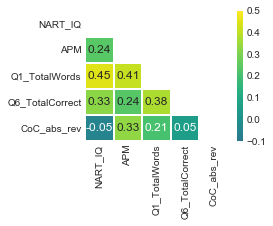

In [3]:
# Behavioural correlation heatmap
beh_tf = data['behav'][0][0][4]
corr = np.corrcoef(beh_tf.T)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(3.2, 2.4))
sns.heatmap(corr,
            vmin=-0.1,
            vmax=0.5,
            cmap='viridis',
            center=0,
            annot=True,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=beh_labels,
            yticklabels=beh_labels)
plt.show()

### Lesion density plot
Our stroke locations are typical for the literature. Usually, this map would be thresholded for a VLSM analysis (~10% of the sample), meaning that only regions around the insula would be tested.

Colourbar indicates overlap across participants. The strange wispy lines are from changing the MNI space of the images (it doesn't affect the lesion-network mapping).

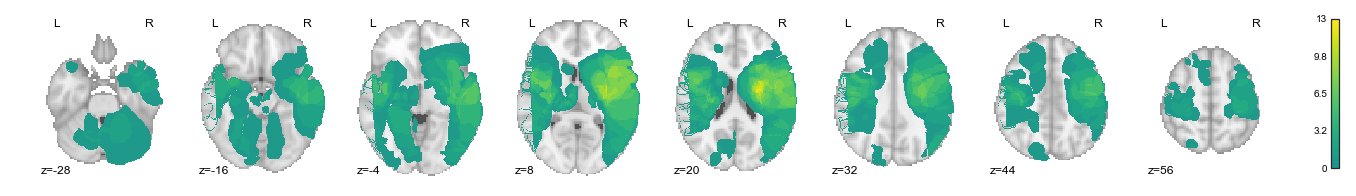

In [4]:
#plot summed lesion map
img = '/Users/luke/Documents/Projects/StrokeNet/Docs/Results/voxelwise/LesionOverlap.nii'
slices = np.arange(-28, 62, 12)
plotting.plot_stat_map(img,
                       threshold=0,
                       colorbar=True,
                       cmap='viridis',
                       display_mode='z',
                       cut_coords=(slices))
plt.show()

### Lesion-connectivity mapping density plot
These are the estimated lesioned connections based on 20 similarly aged and gender matched controls from the NKI database. Nearly every connection is implicated across participants.

Colourbar indicates overlap across participants

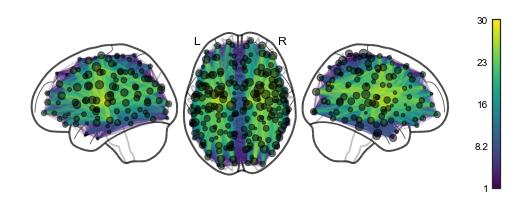

In [5]:
# plot summed lesion-connectivity map
cm = data['Cdiff']
cm[cm > 0] = 1
cm = np.sum(cm, axis=2)
cm = cm + cm.T
cm_degree = np.sum(abs(cm), axis=1)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 100
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=1,
                         edge_vmax=30,
                         colorbar=True,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.25},
                         node_kwargs={'Alpha': 0.50})
plotting.show()
plt.show()

## Dimensionality reduction: multiple correspondance analysis (MCA) results
We used MCA to reduce the potential edges used in the CCA (~10,000) to a smaller number of components (tested from 7 - 20). MCA can be thought of as a alternative to PCA for data that is binary. In our case, a PCA is inappropriate because a vector of connections would include many 0's (not damaged connections) and a few weighted connections, resulting in a non-normal distribution. As an added bonus, using binary data lends itself to comparison with the raw lesion maps (which are also binary).

These maps can be interpreted as the patterns of damage and undamaged connectivity that account for the most variance across participants, i.e. "common lesion connectivity damage patterns". The first two, perhaps not surprisingly are left and right hemisphere damage stemming from the insula.

Mean variance explained for components (%) [20.51294935  9.69037583  5.13592384  4.66652438  4.14142755  3.49680669
  3.10184957  2.75664116  2.58948542  2.4559511 ]


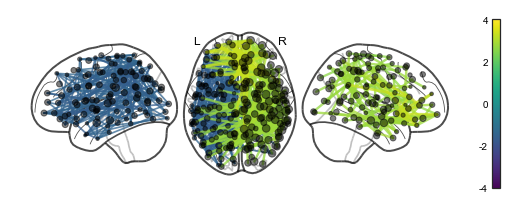

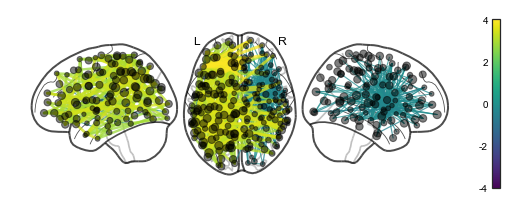

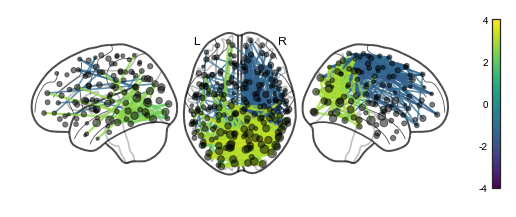

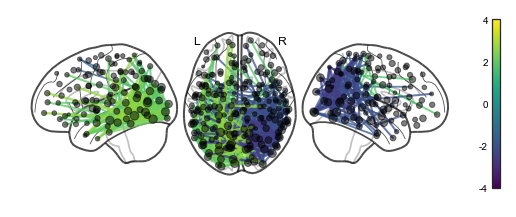

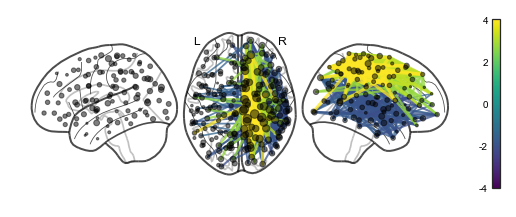

In [6]:
# plot top 5 components from MCA
var_explained = data['MCA'][0][0][4]
print('Mean variance explained for components (%)',
      np.mean(var_explained, axis=0) * 100)

components = data['MCA'][0][0][6]
for comp in range(0, 5):
    cm = components[:, :, comp]
    cm = cm + cm.T
    cm_degree = np.sum(abs(cm), axis=1)
    cm = do_threshold(cm, num_edge=500)
    cm_degree_plot = (cm_degree / np.max(cm_degree)) * 75
    plotting.plot_connectome(cm,
                             MNIcoordinates,
                             node_size=cm_degree_plot,
                             node_color='black',
                             edge_cmap='viridis',
                             edge_vmin=-4,
                             edge_vmax=4,
                             colorbar=True,
                             display_mode='lzr',
                             edge_kwargs={'Alpha': 0.75},
                             node_kwargs={'Alpha': 0.50})
    plotting.show()

## CCA Results
Only one mode is significant after correcting via permutations. It loads positively onto the APM and Spatial Neglect, and neglativly onto verbal fluency. The connectivity is pretty clearly determined by damage on the left associated with language and the right associated with spatial neglect/APM.

When investigating the associted networks a fairly clear patterns emerges whereby the APM/spatial neglect/ right hemisphere damage is associated with control and attention networks - makes sense! The left-hemisphere /verbal fluency damage is associated with more diffuse, potentially subcortical connection damage.

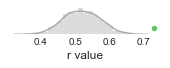

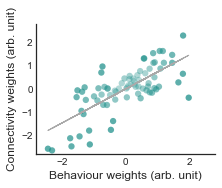

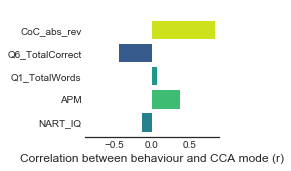

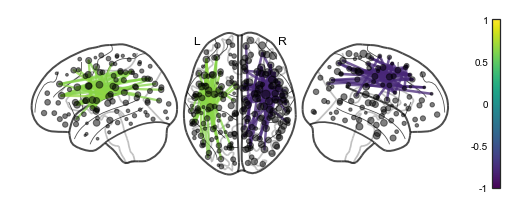

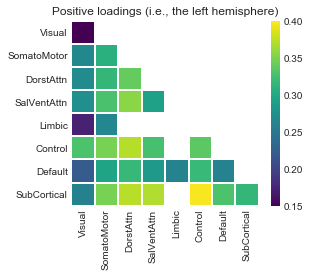

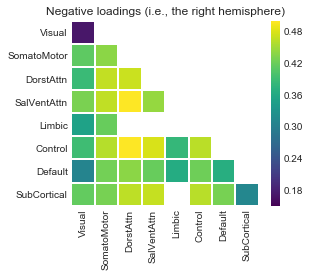

In [7]:
#plot CCA results for mode 1
U = data['CCA'][0][0][2]
V = data['CCA'][0][0][3]
r = data['CCA'][0][0][4]
r_perms = data['CCA'][0][0][9]
behaviour_loading = data['CCA'][0][0][12]
modes = data['CCA'][0][0][11]
real_values = data['CCA'][0][0][6]
predicted_values = data['CCA'][0][0][5]
mode = 0
predicted_values = predicted_values[:, :, mode]
r_values = data['CCA'][0][0][7]
r_values = r_values[:,mode]
perm_r_values = data['CCA'][0][0][10]

U = U[:, :, mode]
U = np.nanmean(U, axis=1)
V = V[:, :, mode]
V = np.nanmean(V, axis=1)
r = r[:, mode]

mode_UV_plot(U, V, r, r_perms)
mode_BW_plot(behaviour_loading[:, mode])

cm = modes[:, :, mode] + modes[:, :, mode].T
cm_degree = np.sum(abs(cm), axis=1)
cm = do_threshold(cm, num_edge=100)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 75
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=-1,
                         edge_vmax=1,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.75},
                         node_kwargs={'Alpha': 0.50},
                         colorbar=True)
plotting.show()

#network level description
net_values = data['CCA'][0][0][13]
#positive
pos = net_values[:, :, 0, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask,k=1)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos,
            vmin=0.15,
            vmax=0.4,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Positive loadings (i.e., the left hemisphere)')
plt.show()

#negative
pos = net_values[:, :, 1, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask,k=1)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos * -1,
            vmin=0.15,
            vmax=0.5,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Negative loadings (i.e., the right hemisphere)')
plt.show()

### Leave-one-out prediction of behavioural scores
The CCA can predict 3/5 behaviours (in line with the behavioural loadings above).

Remember that we wouldn't expect it to predict the NART (so, 3/4).

This is kind of impressive because it is distilling each individual into a single value + a simple transformation for each behaviour to acheive this level of accuracy. Suggests that a low dimensional description is quite useful for predicting a left out individual's cognitive scores (on some tasks).

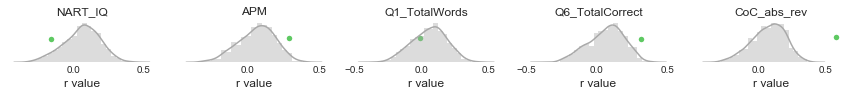

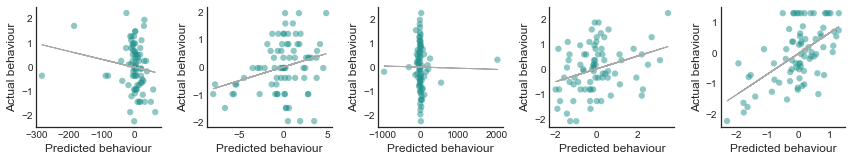

In [8]:
mode_prediction_plot(real_values, predicted_values, r_values, perm_r_values)

## Neurosynth reverse inference analysis

The last analysis I have done is using neurosynth to conduct a meta-analysis on the top five positive and negatively weighted regions from the CCA.

This method is relatively simple, for each roi it does a meta-analytic comparison of all studies that activate within the region versus all the ones that don't. The final result is a set of labels associated with the activated studies.

I'm interpreting the results in the following way:
- We only measure five behavioural variables, but it is likely that our results extend beyond these cognitive faculties. i.e., this is weak (reverse inference based) evidence for generalization.
- The most 'interesting' effects tend to occur away from the Insula, suggesting that connections, rather than localised damage might be a key factor.

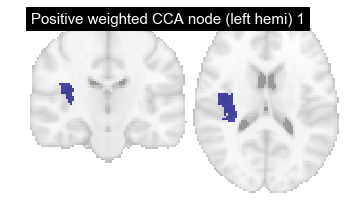

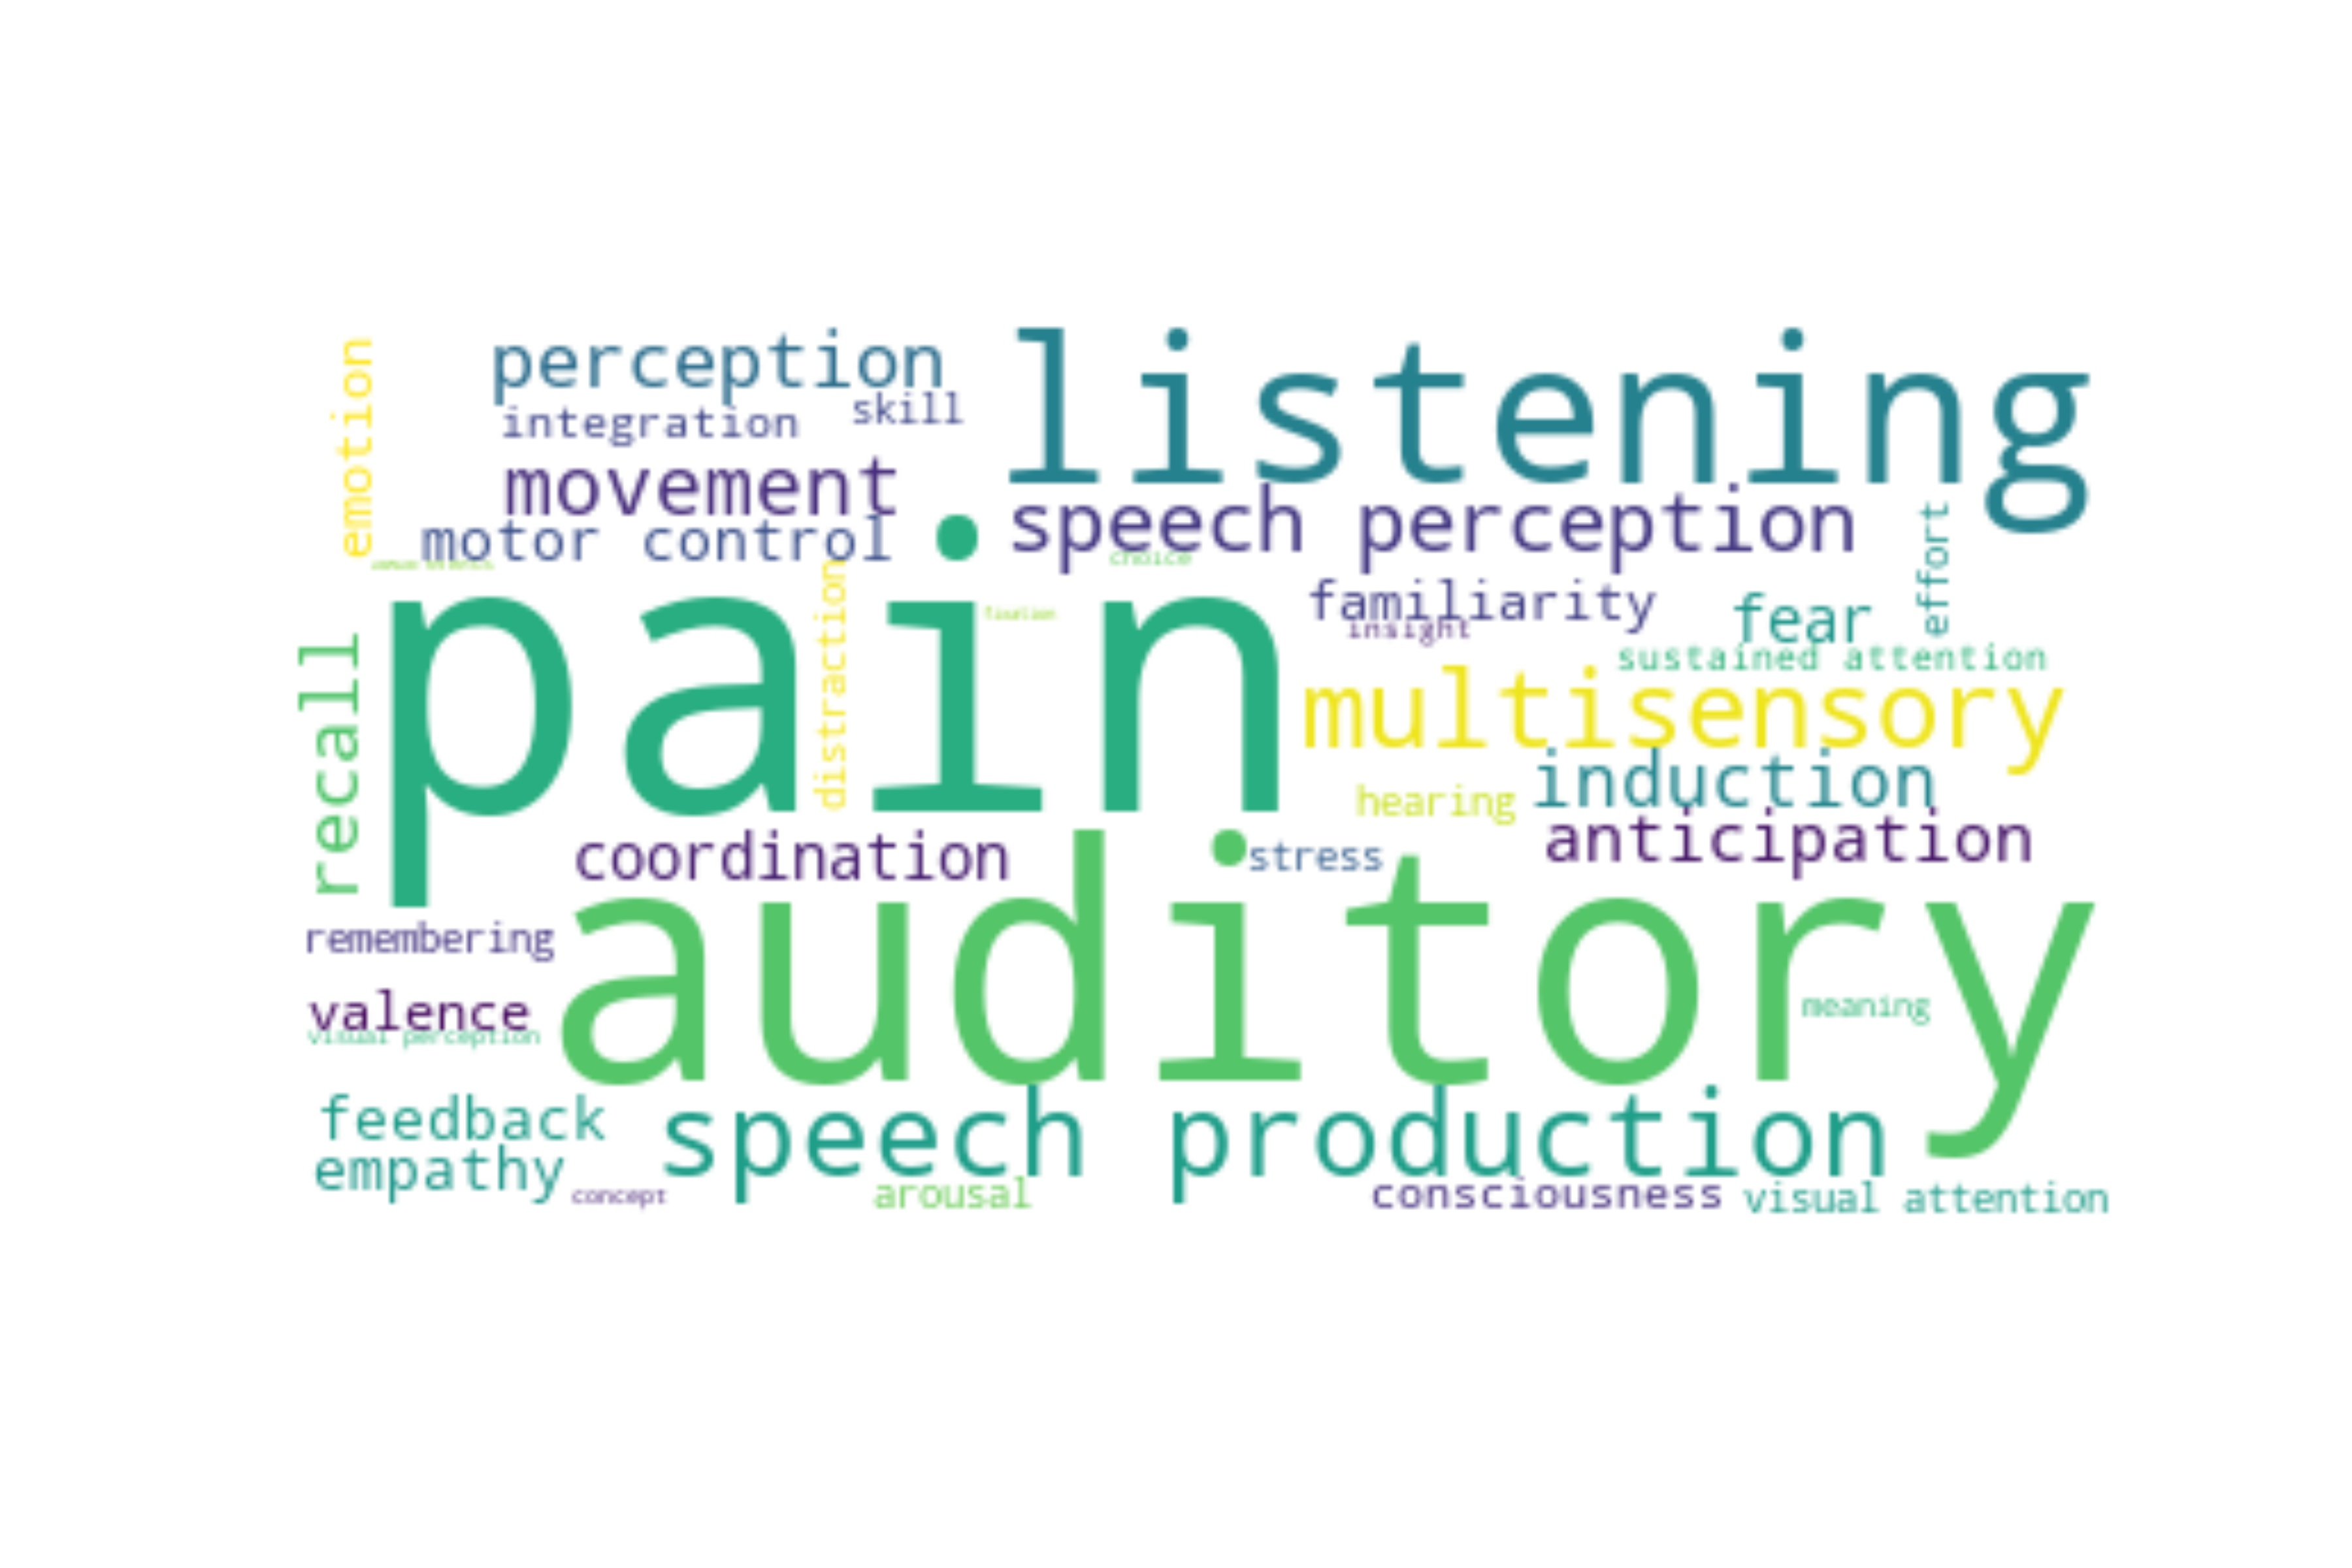

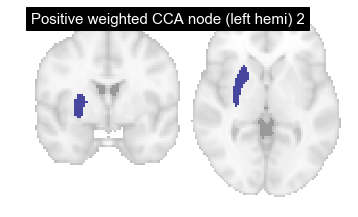

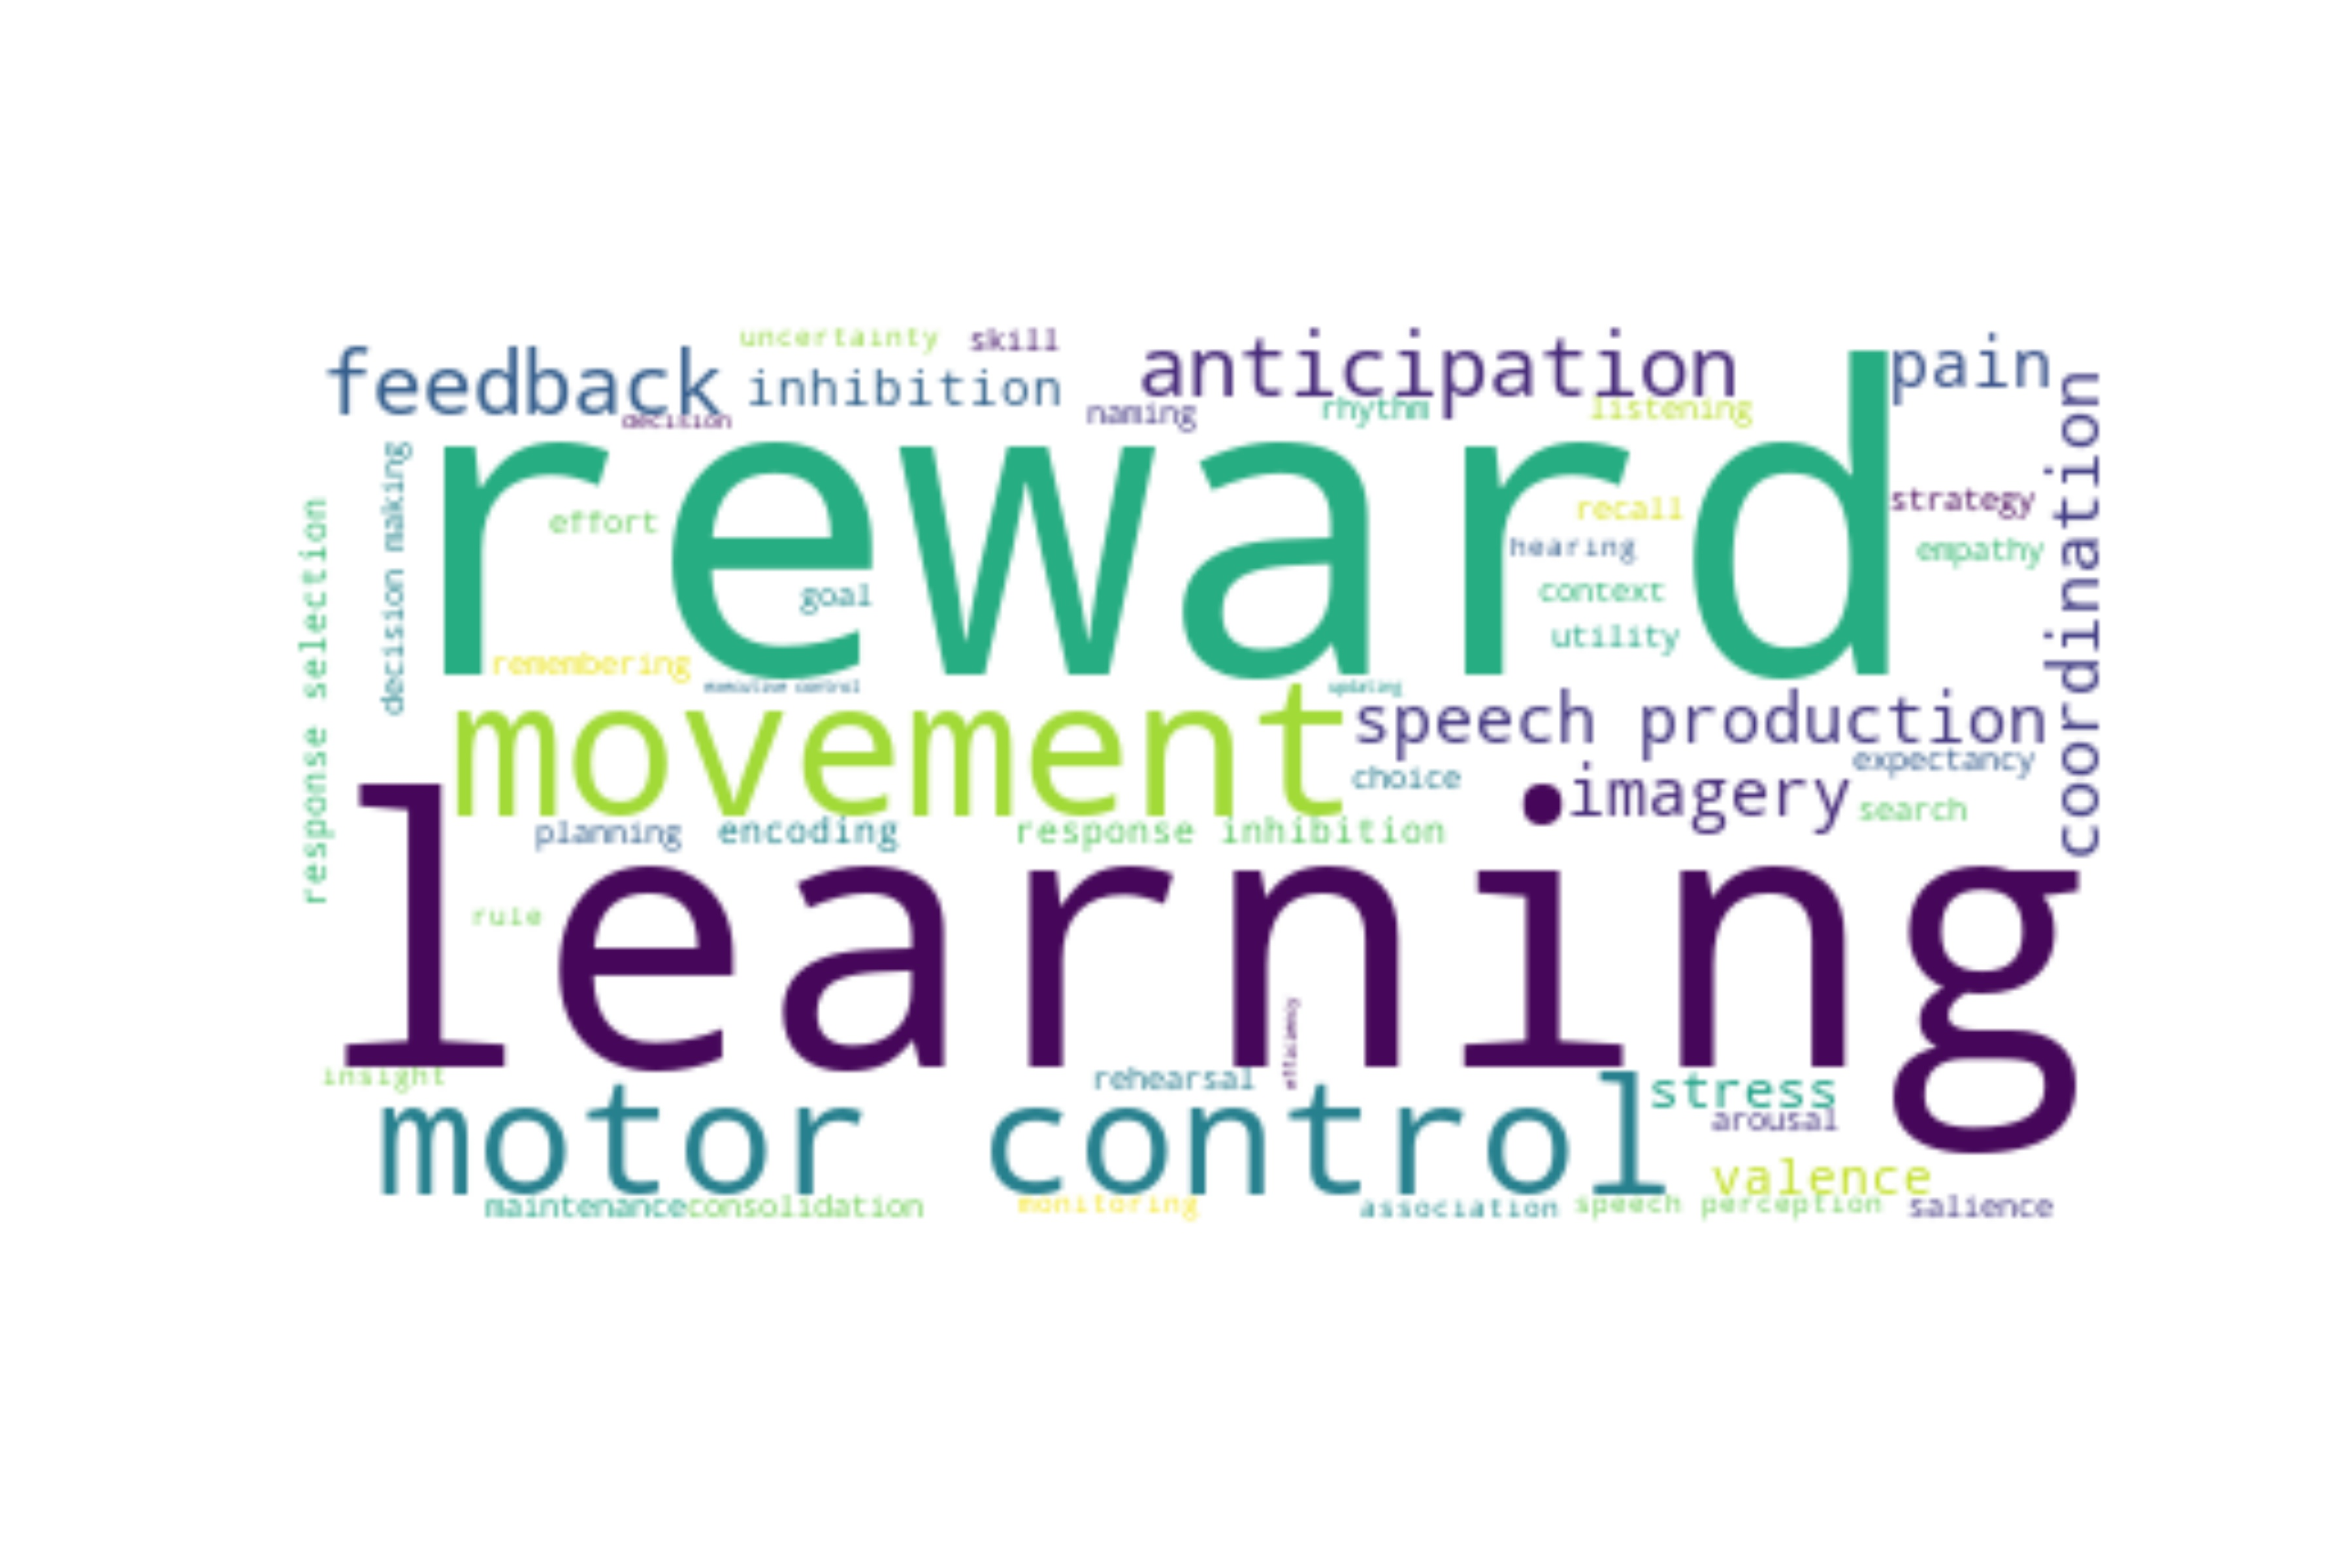

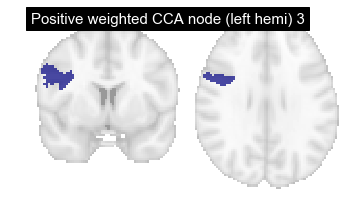

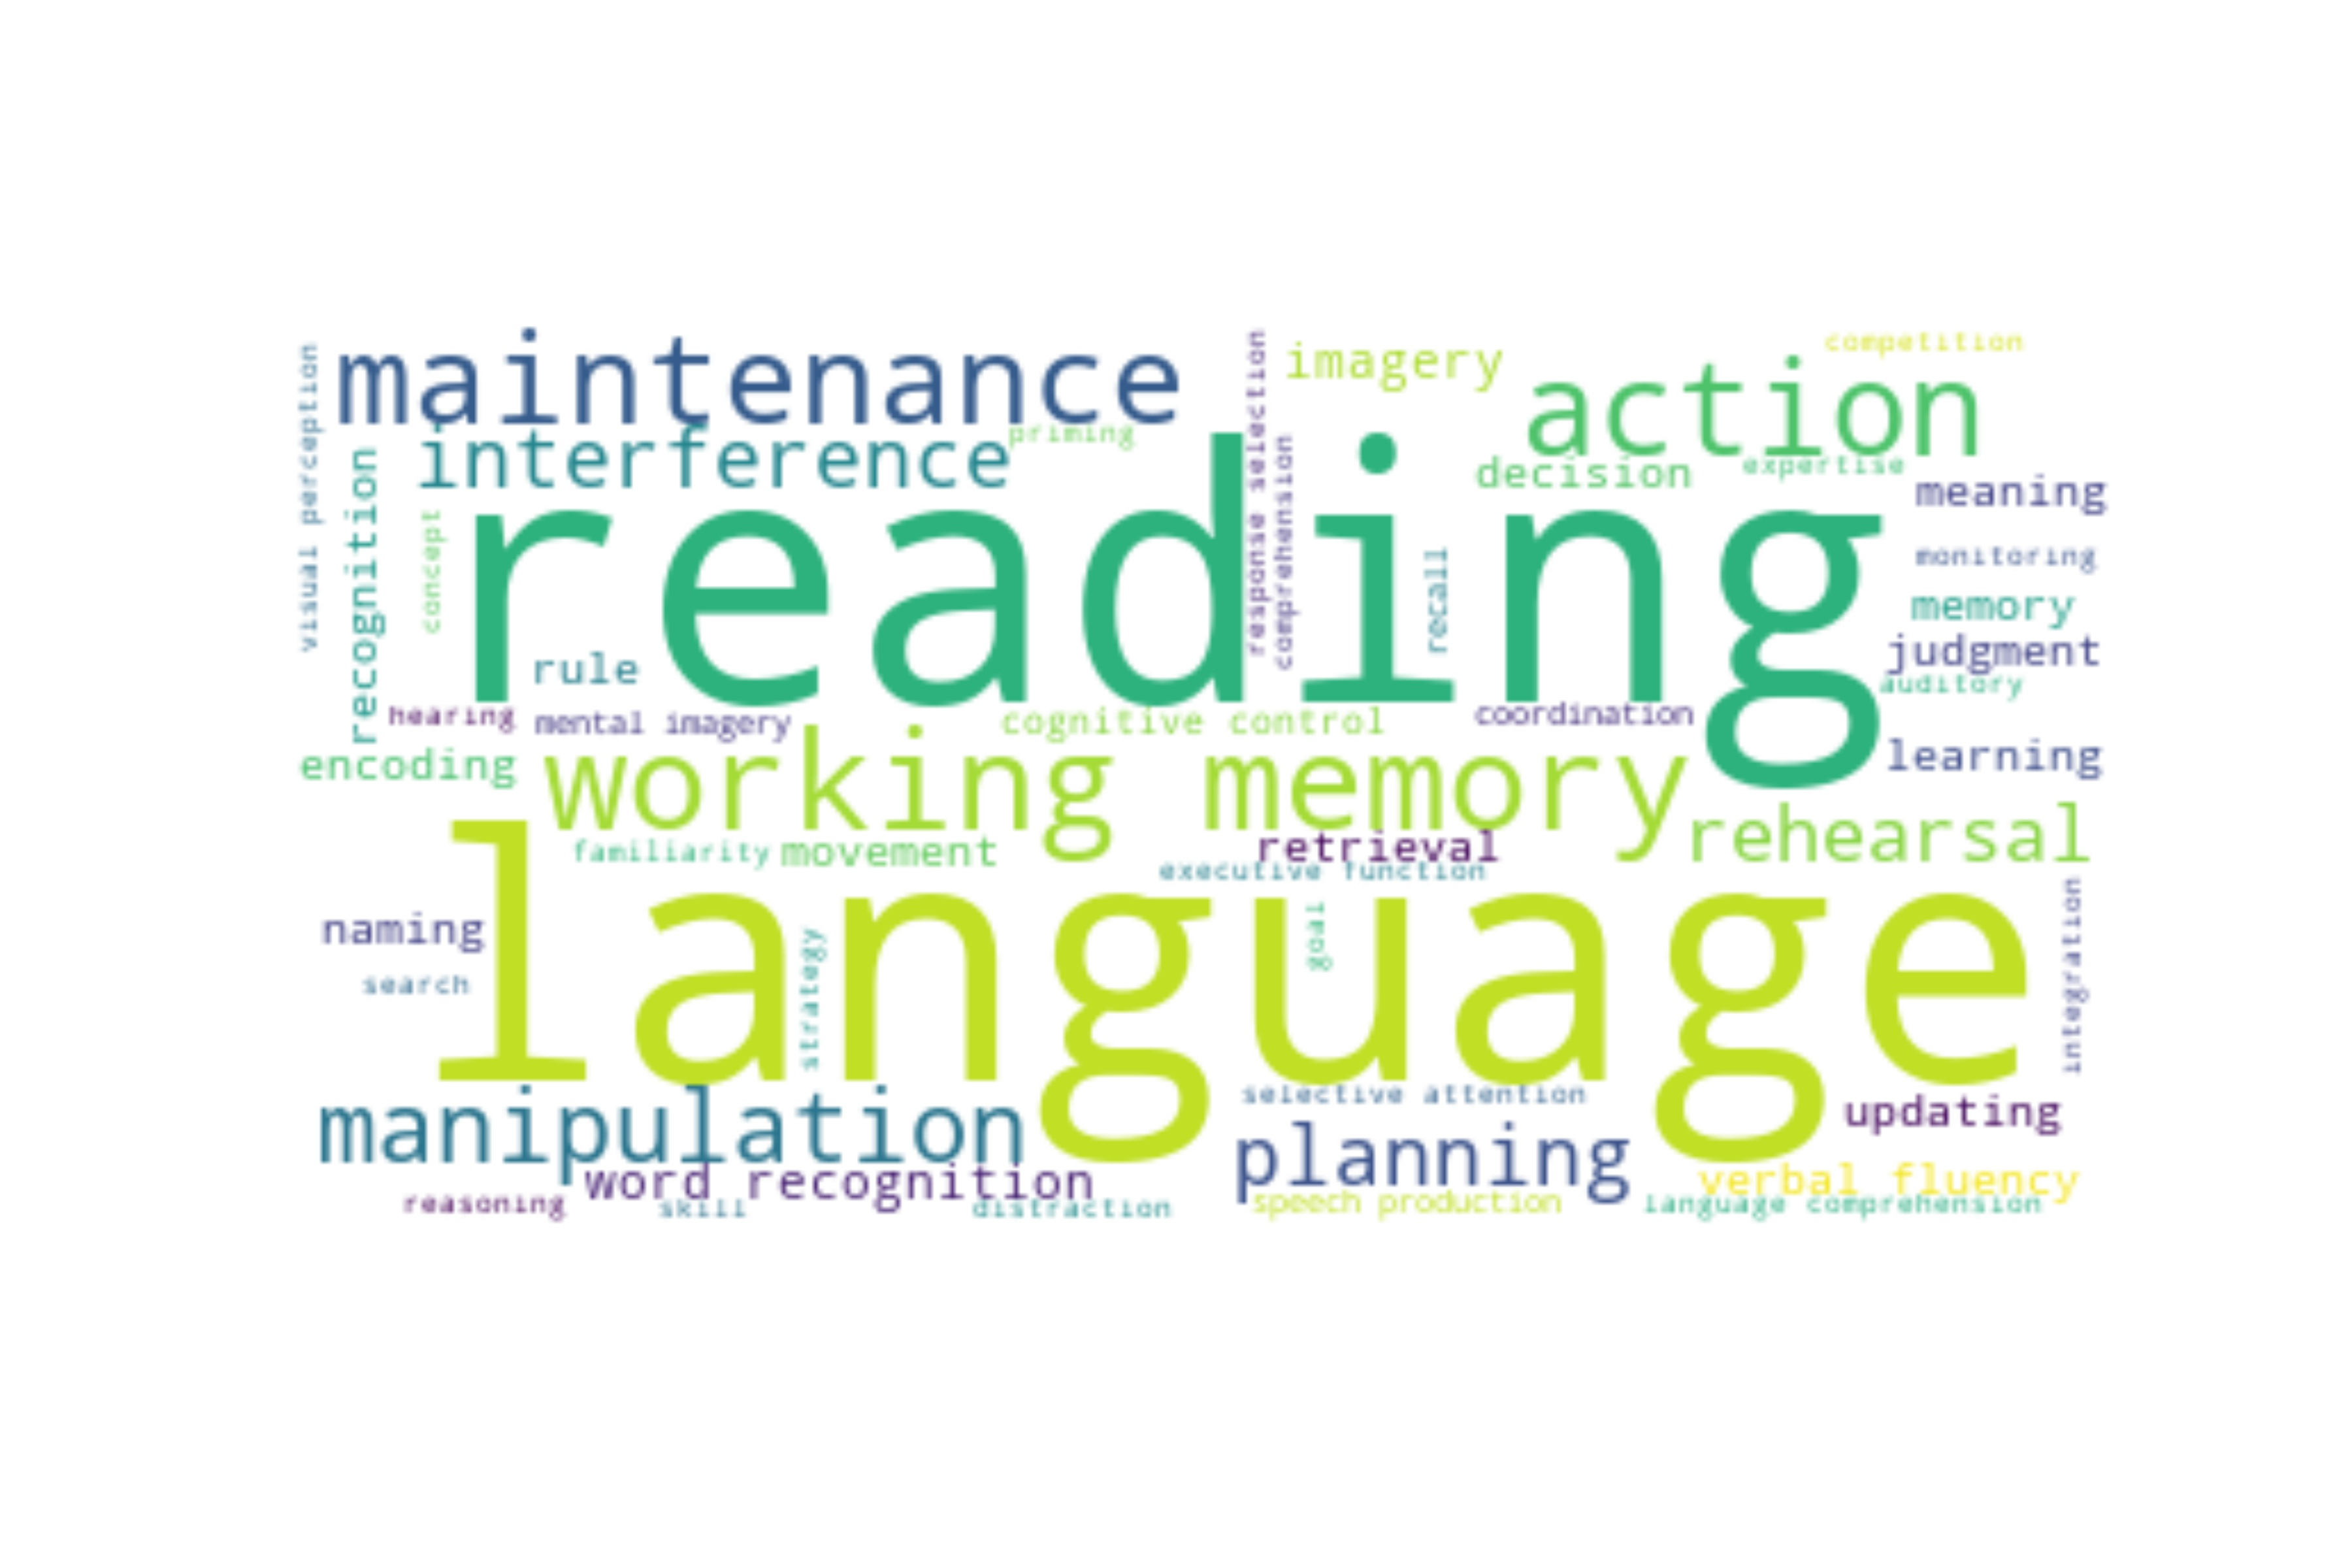

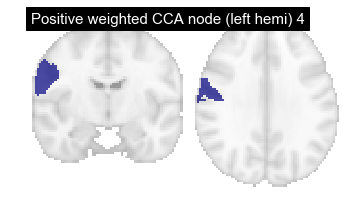

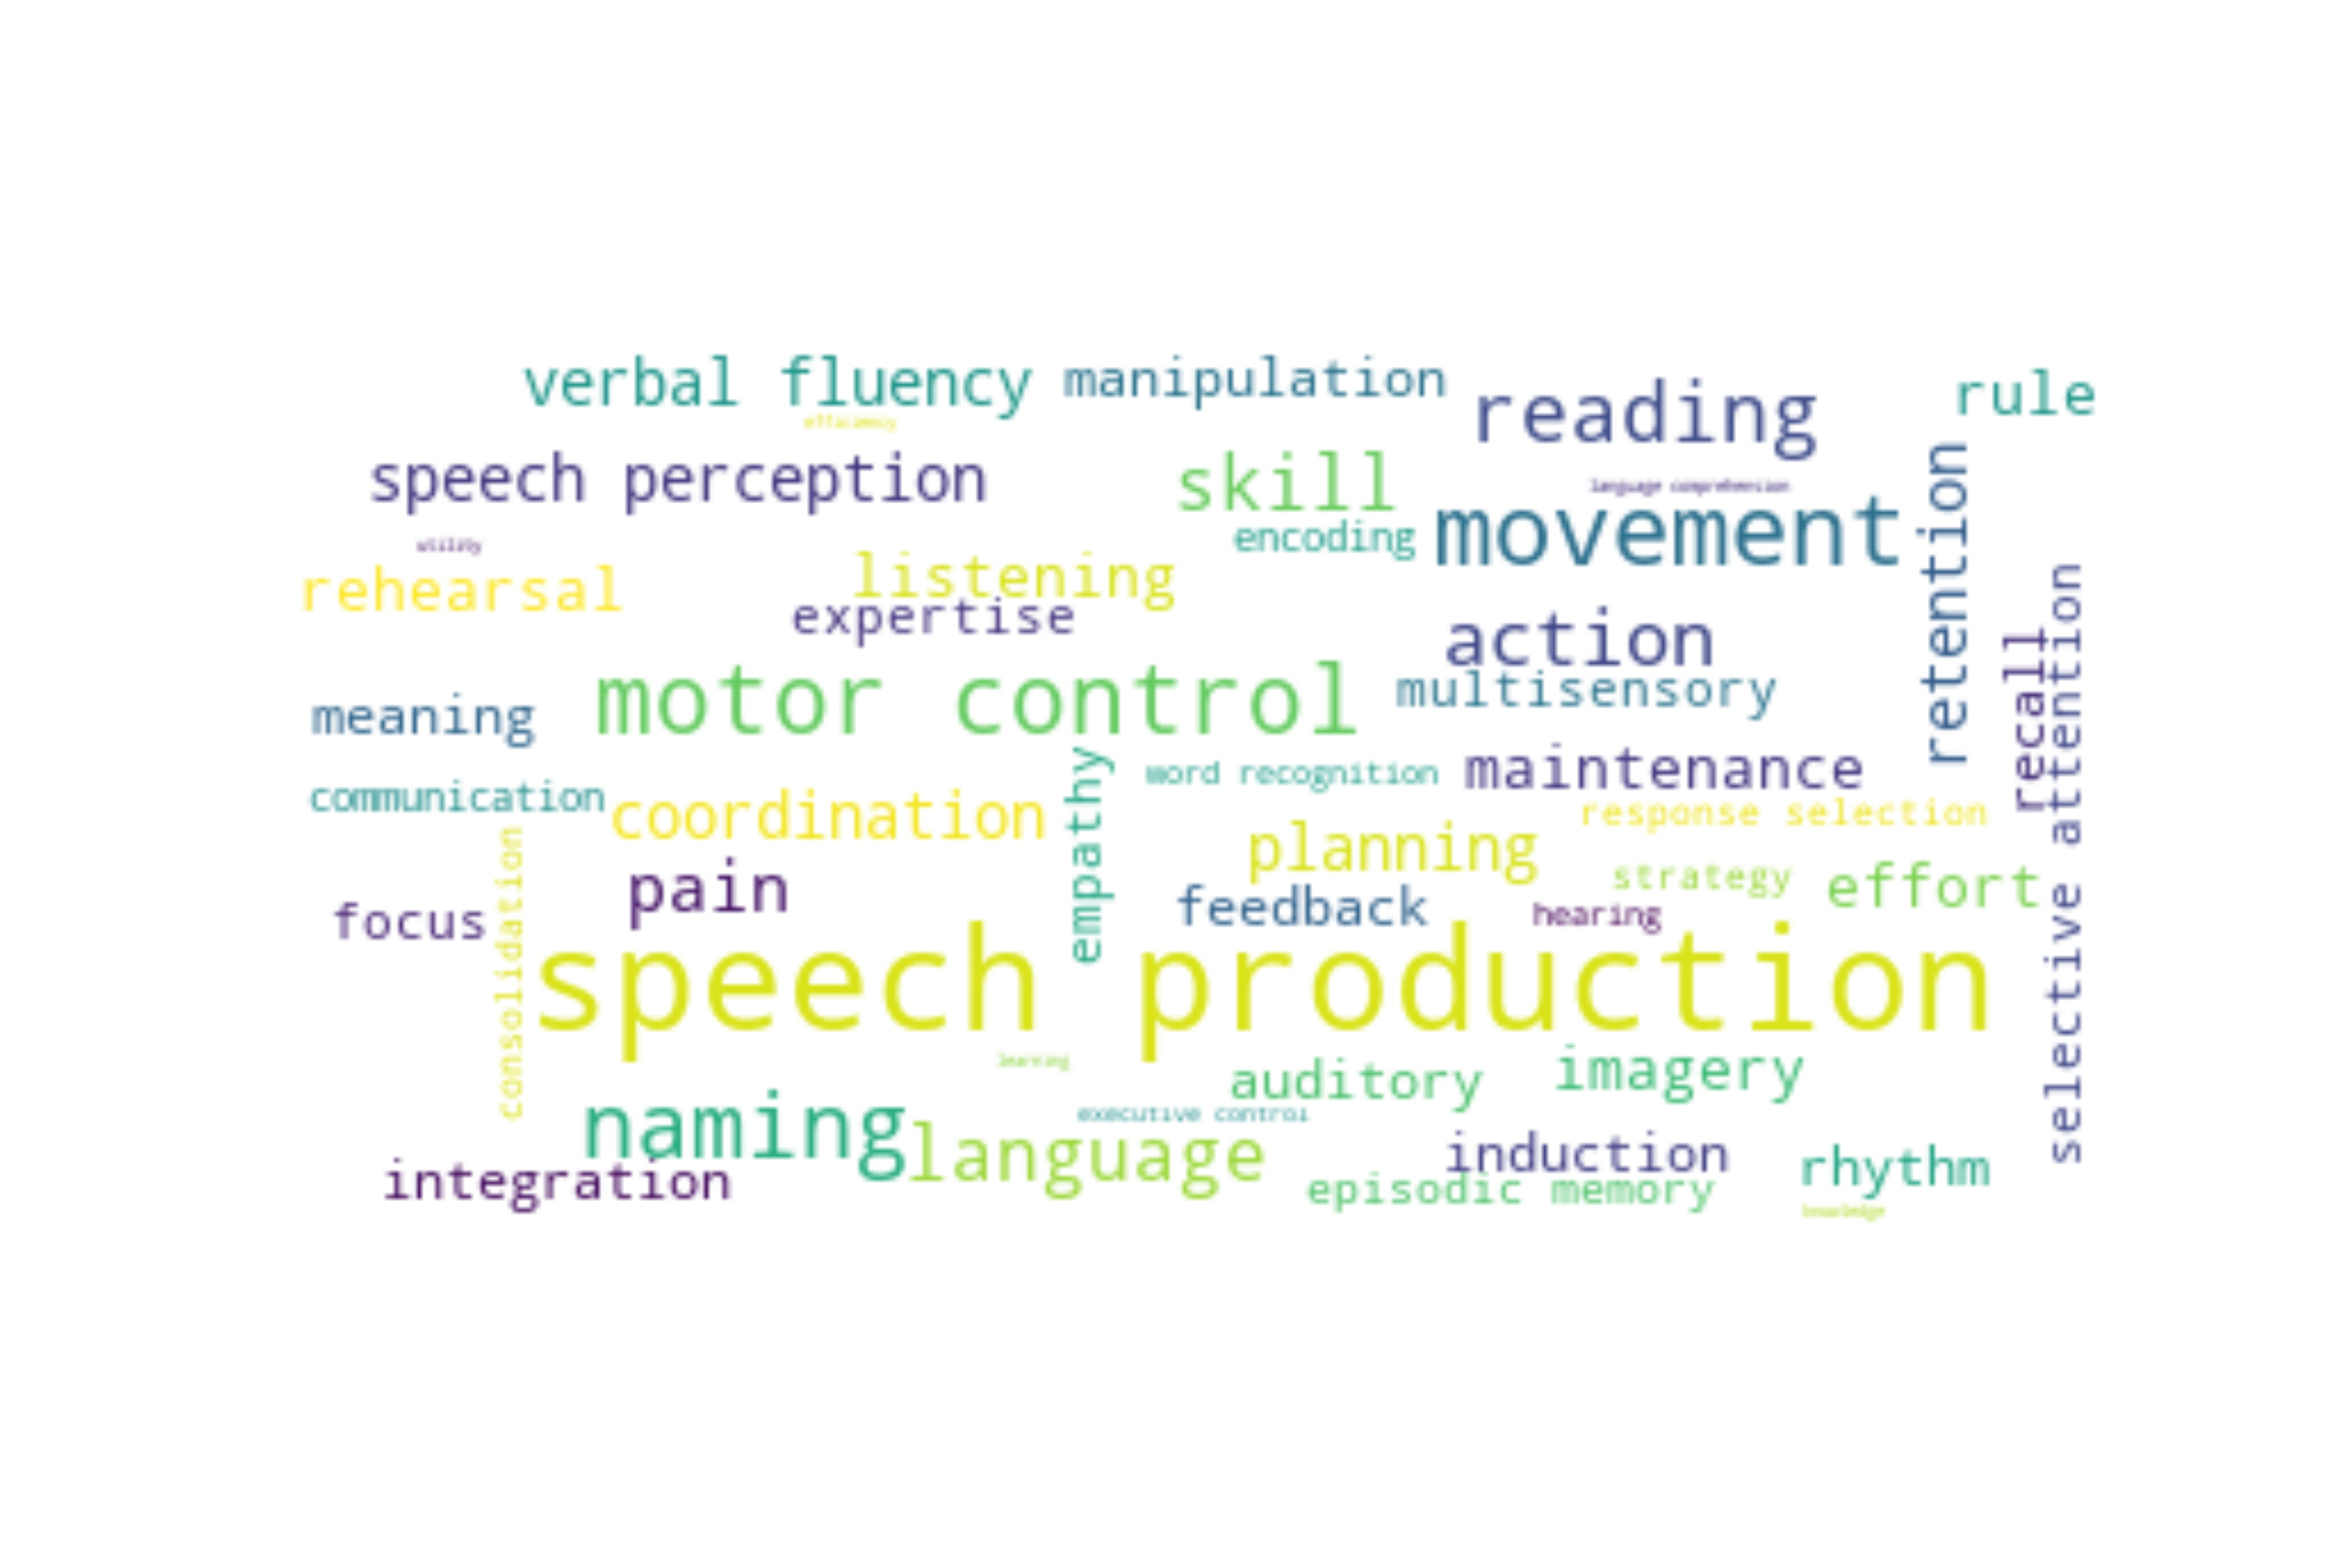

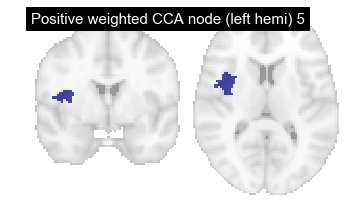

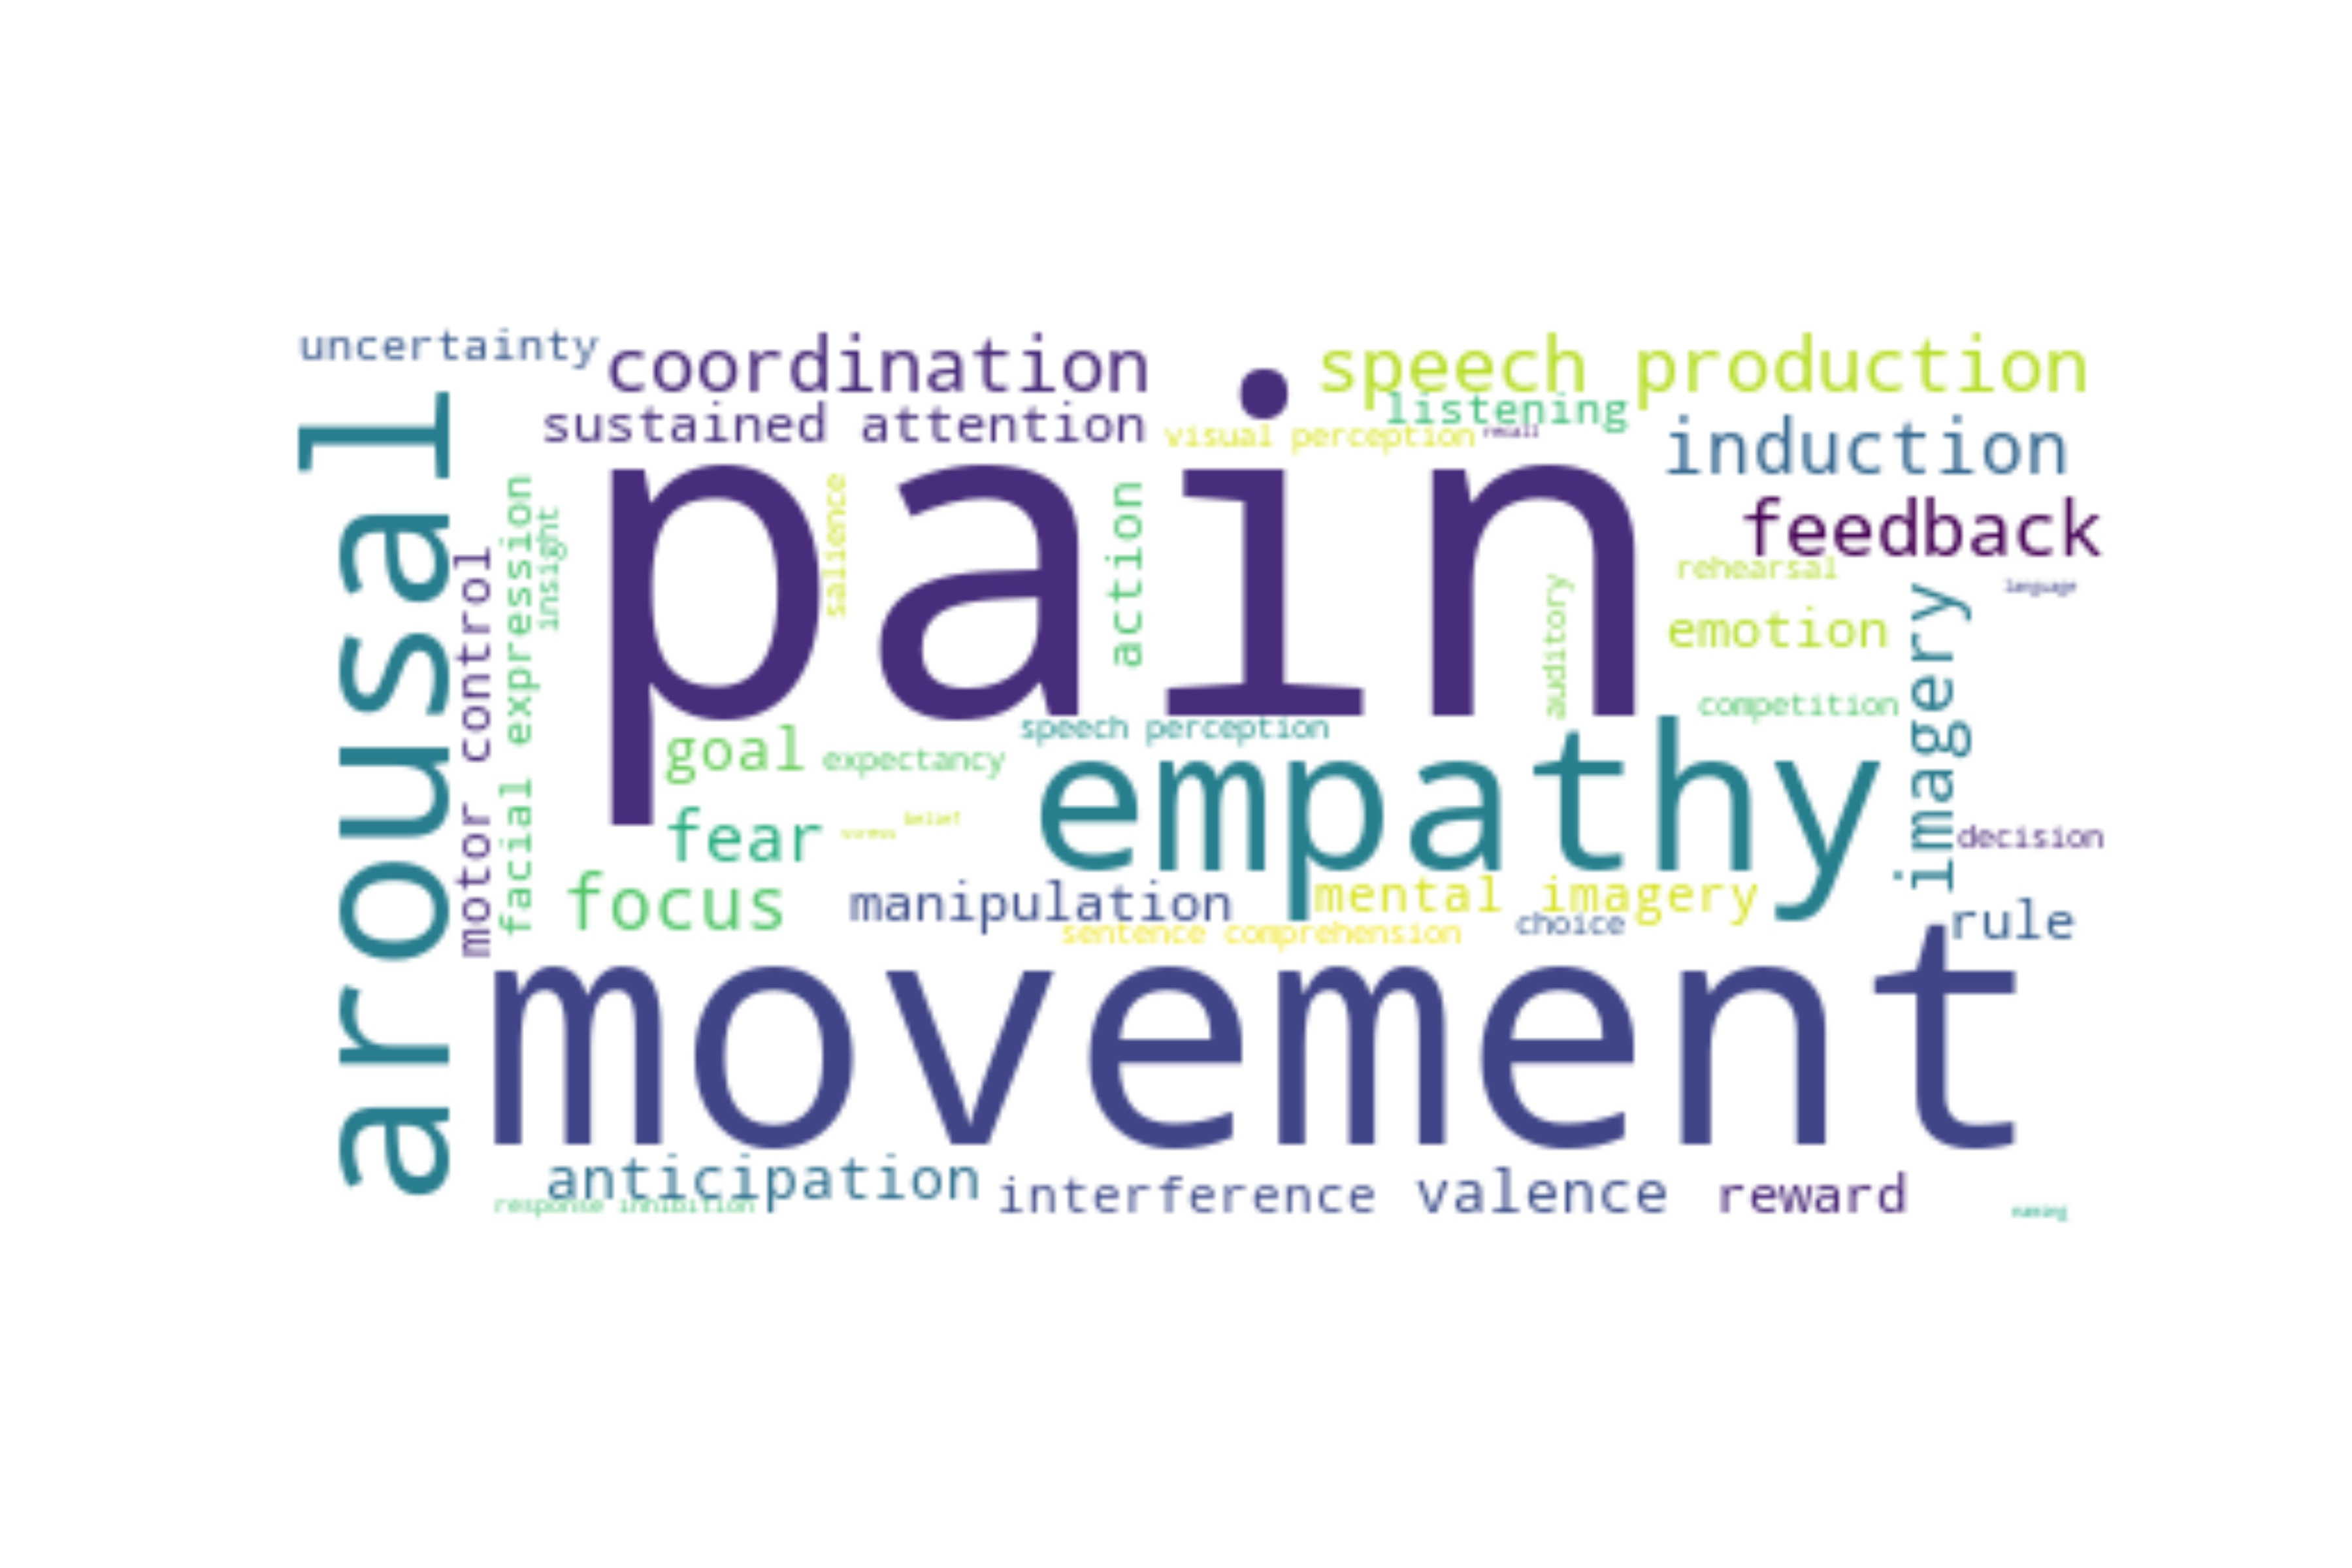

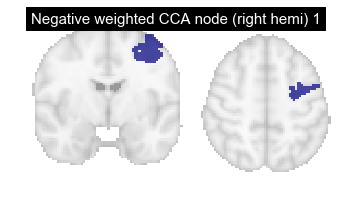

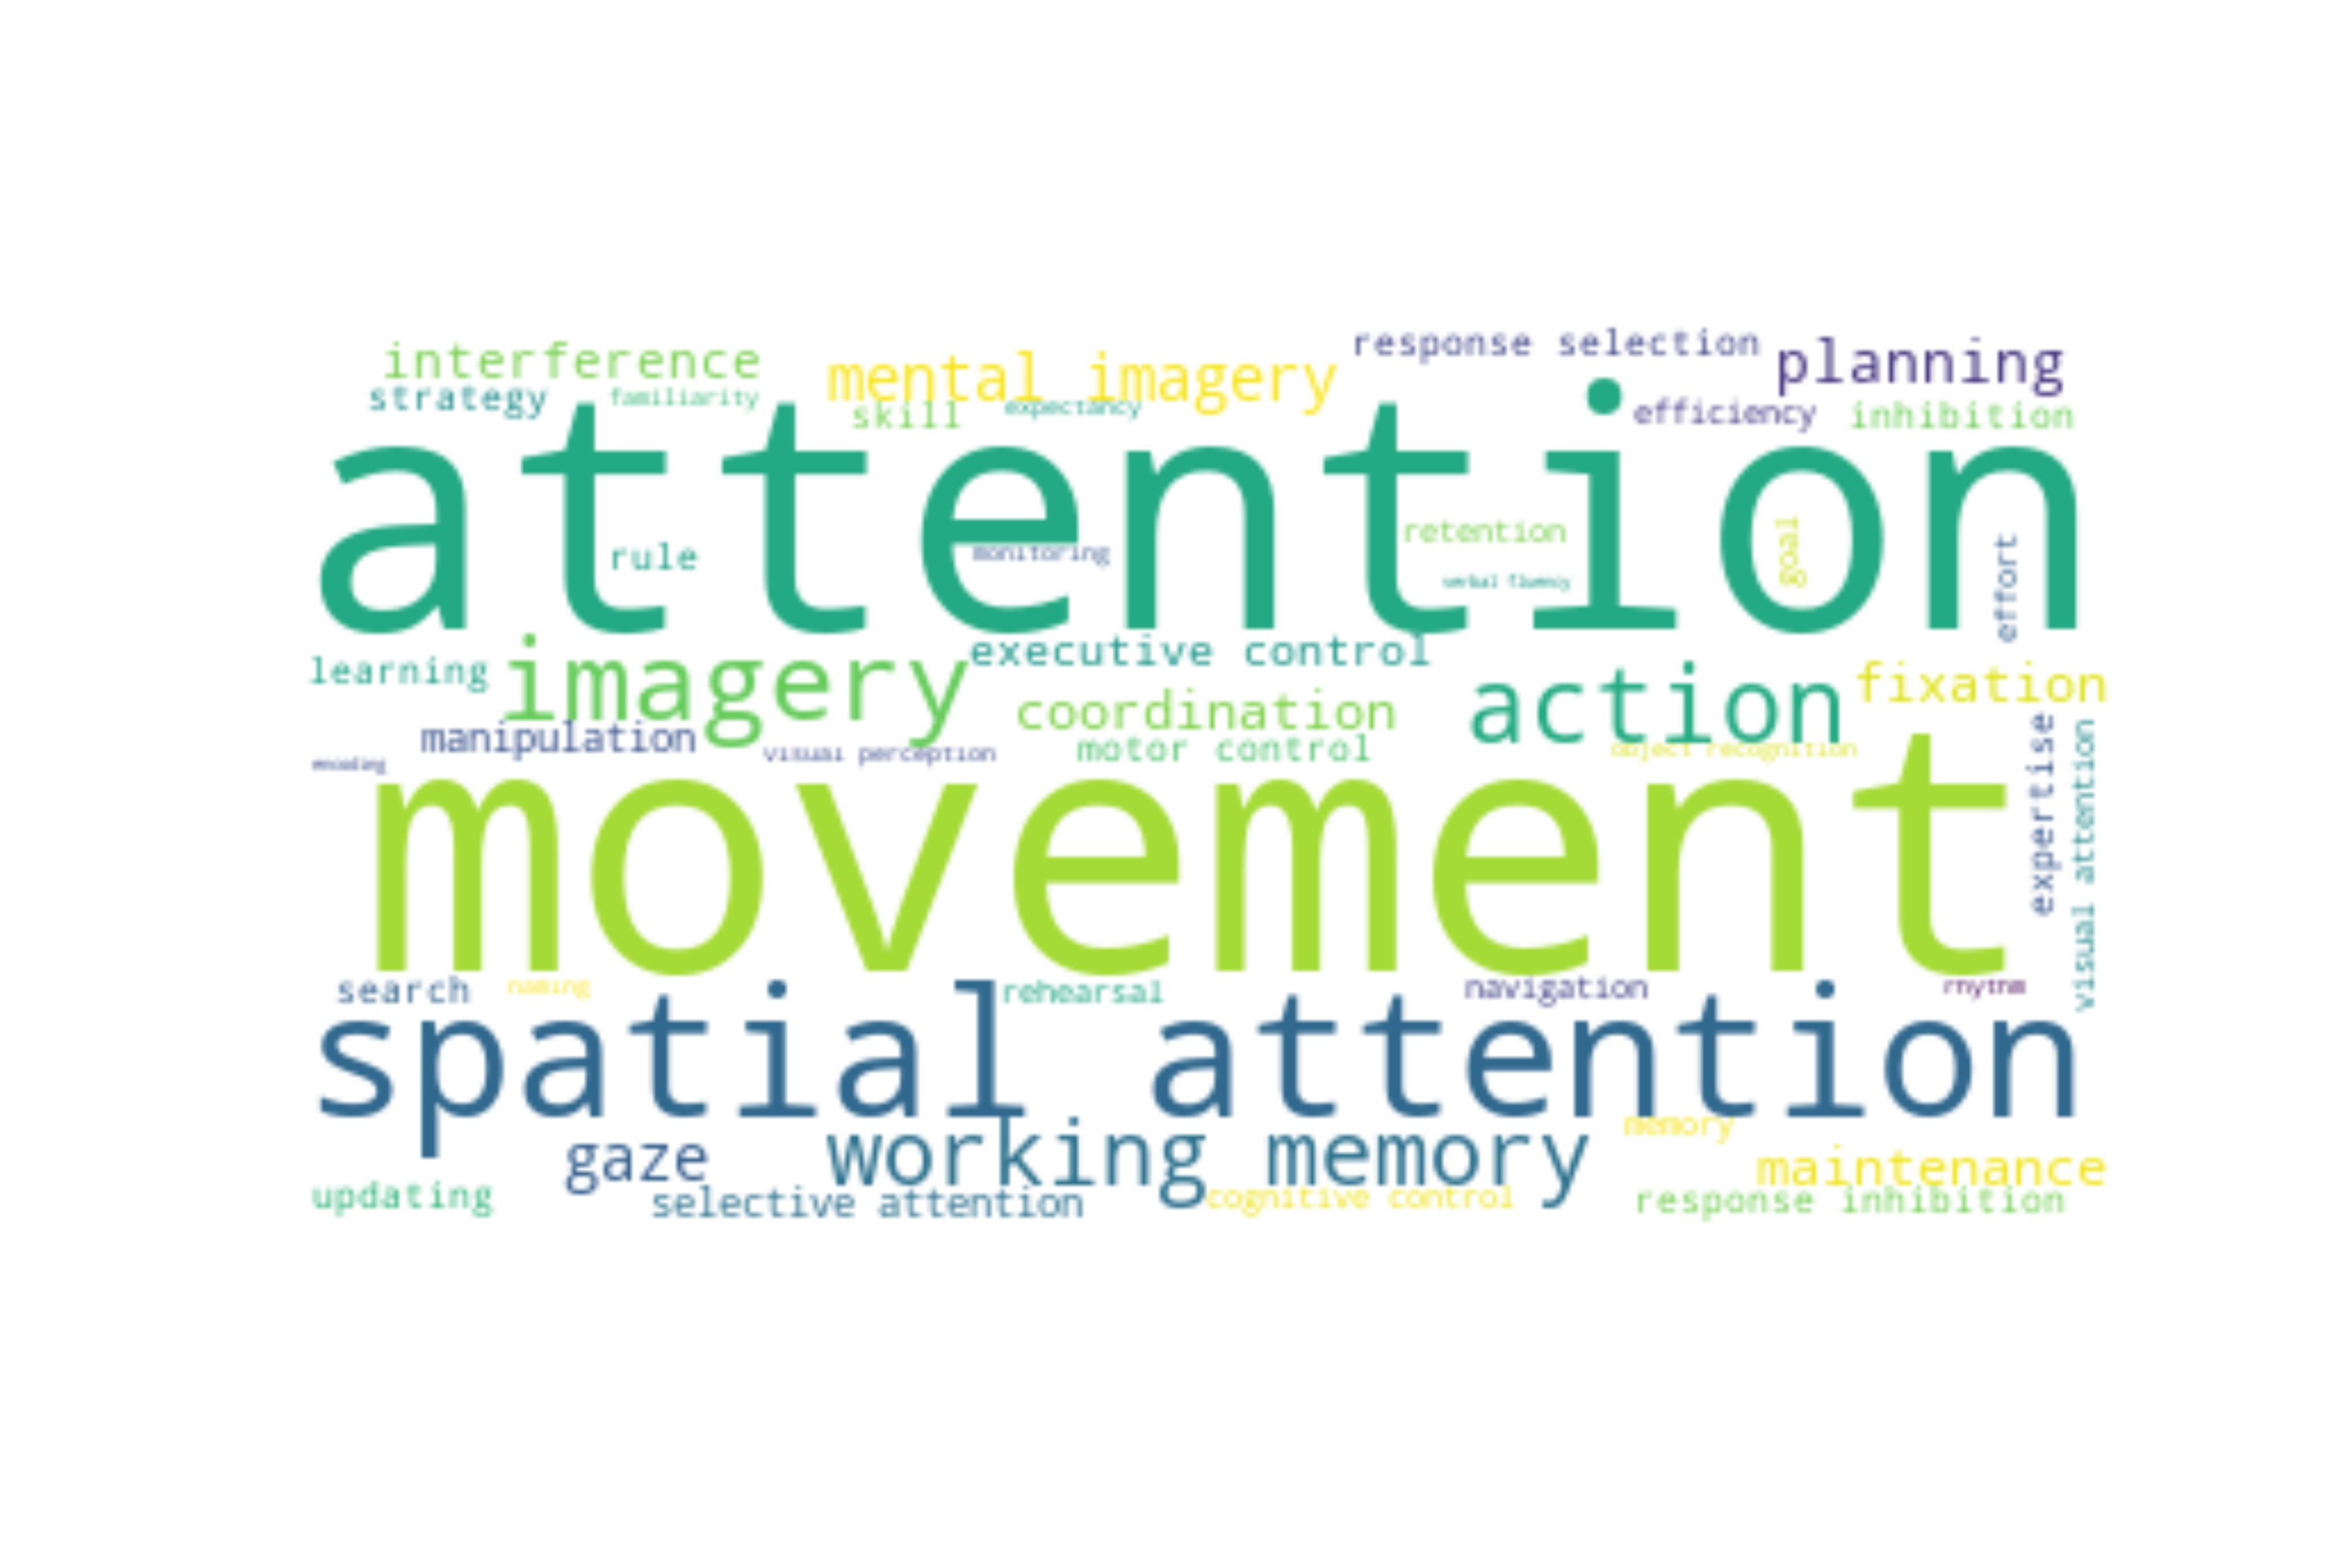

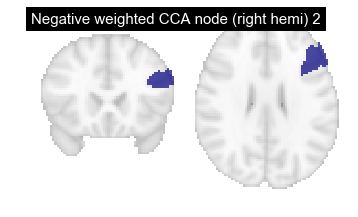

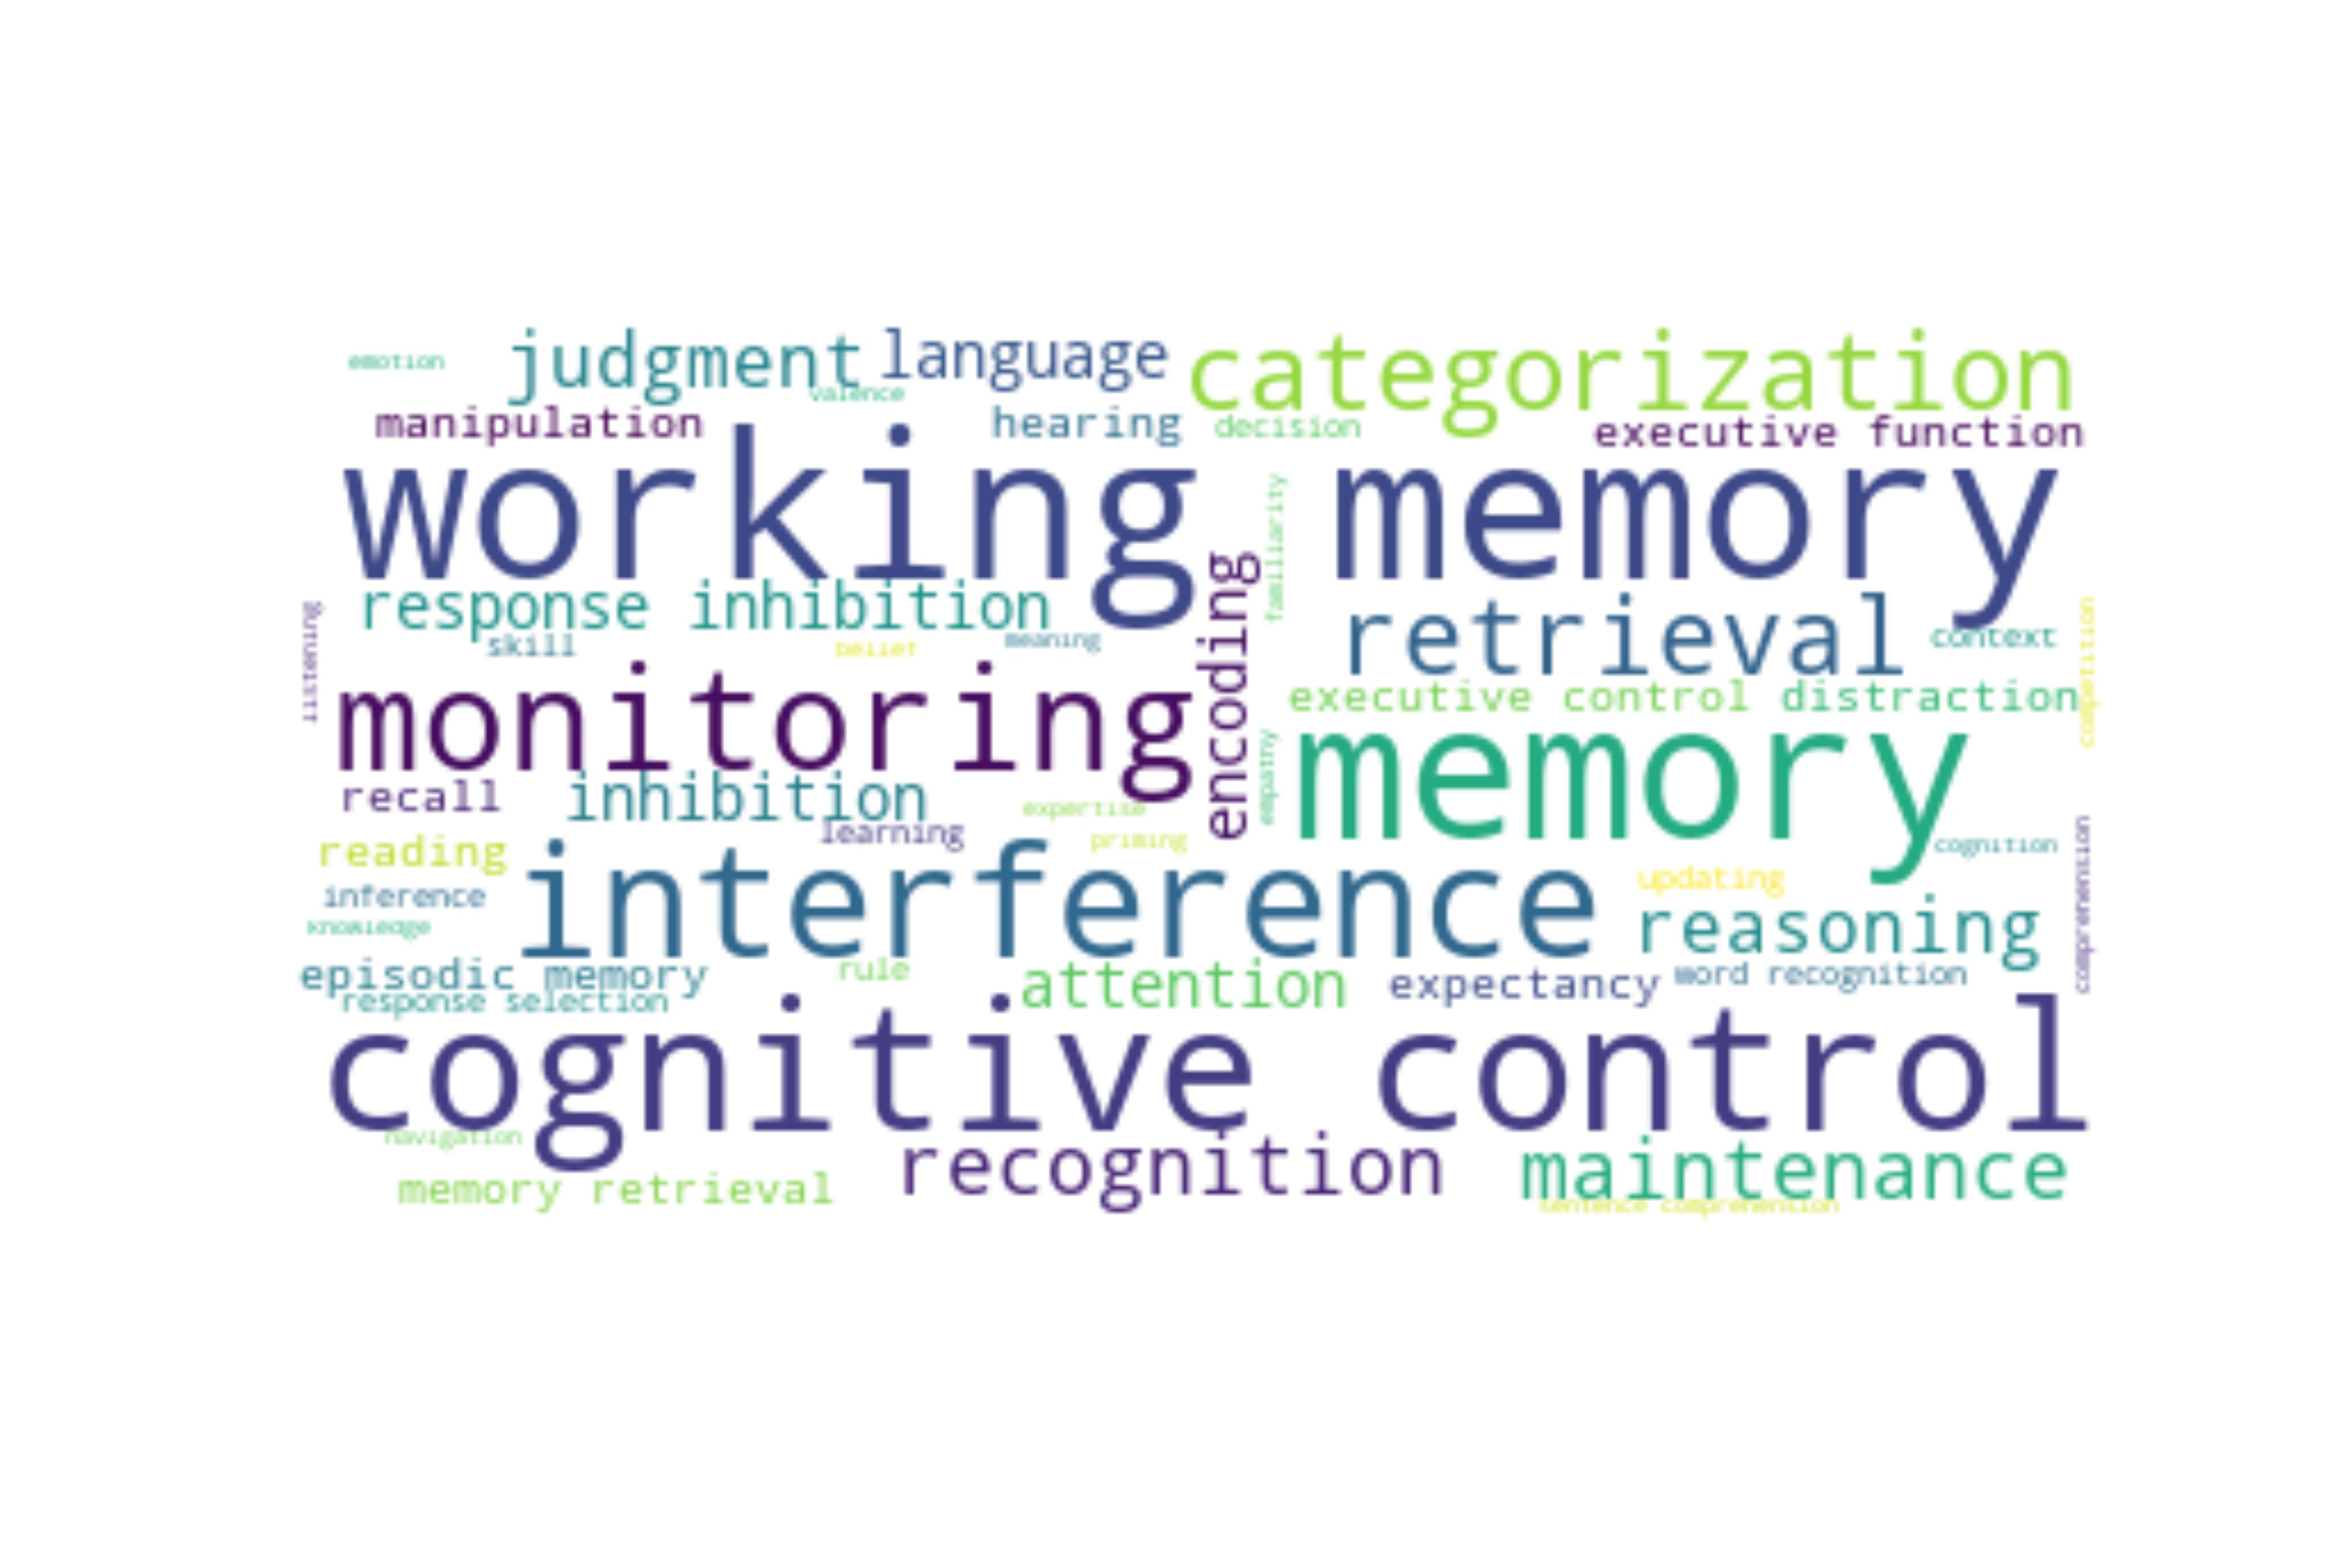

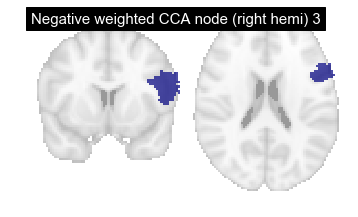

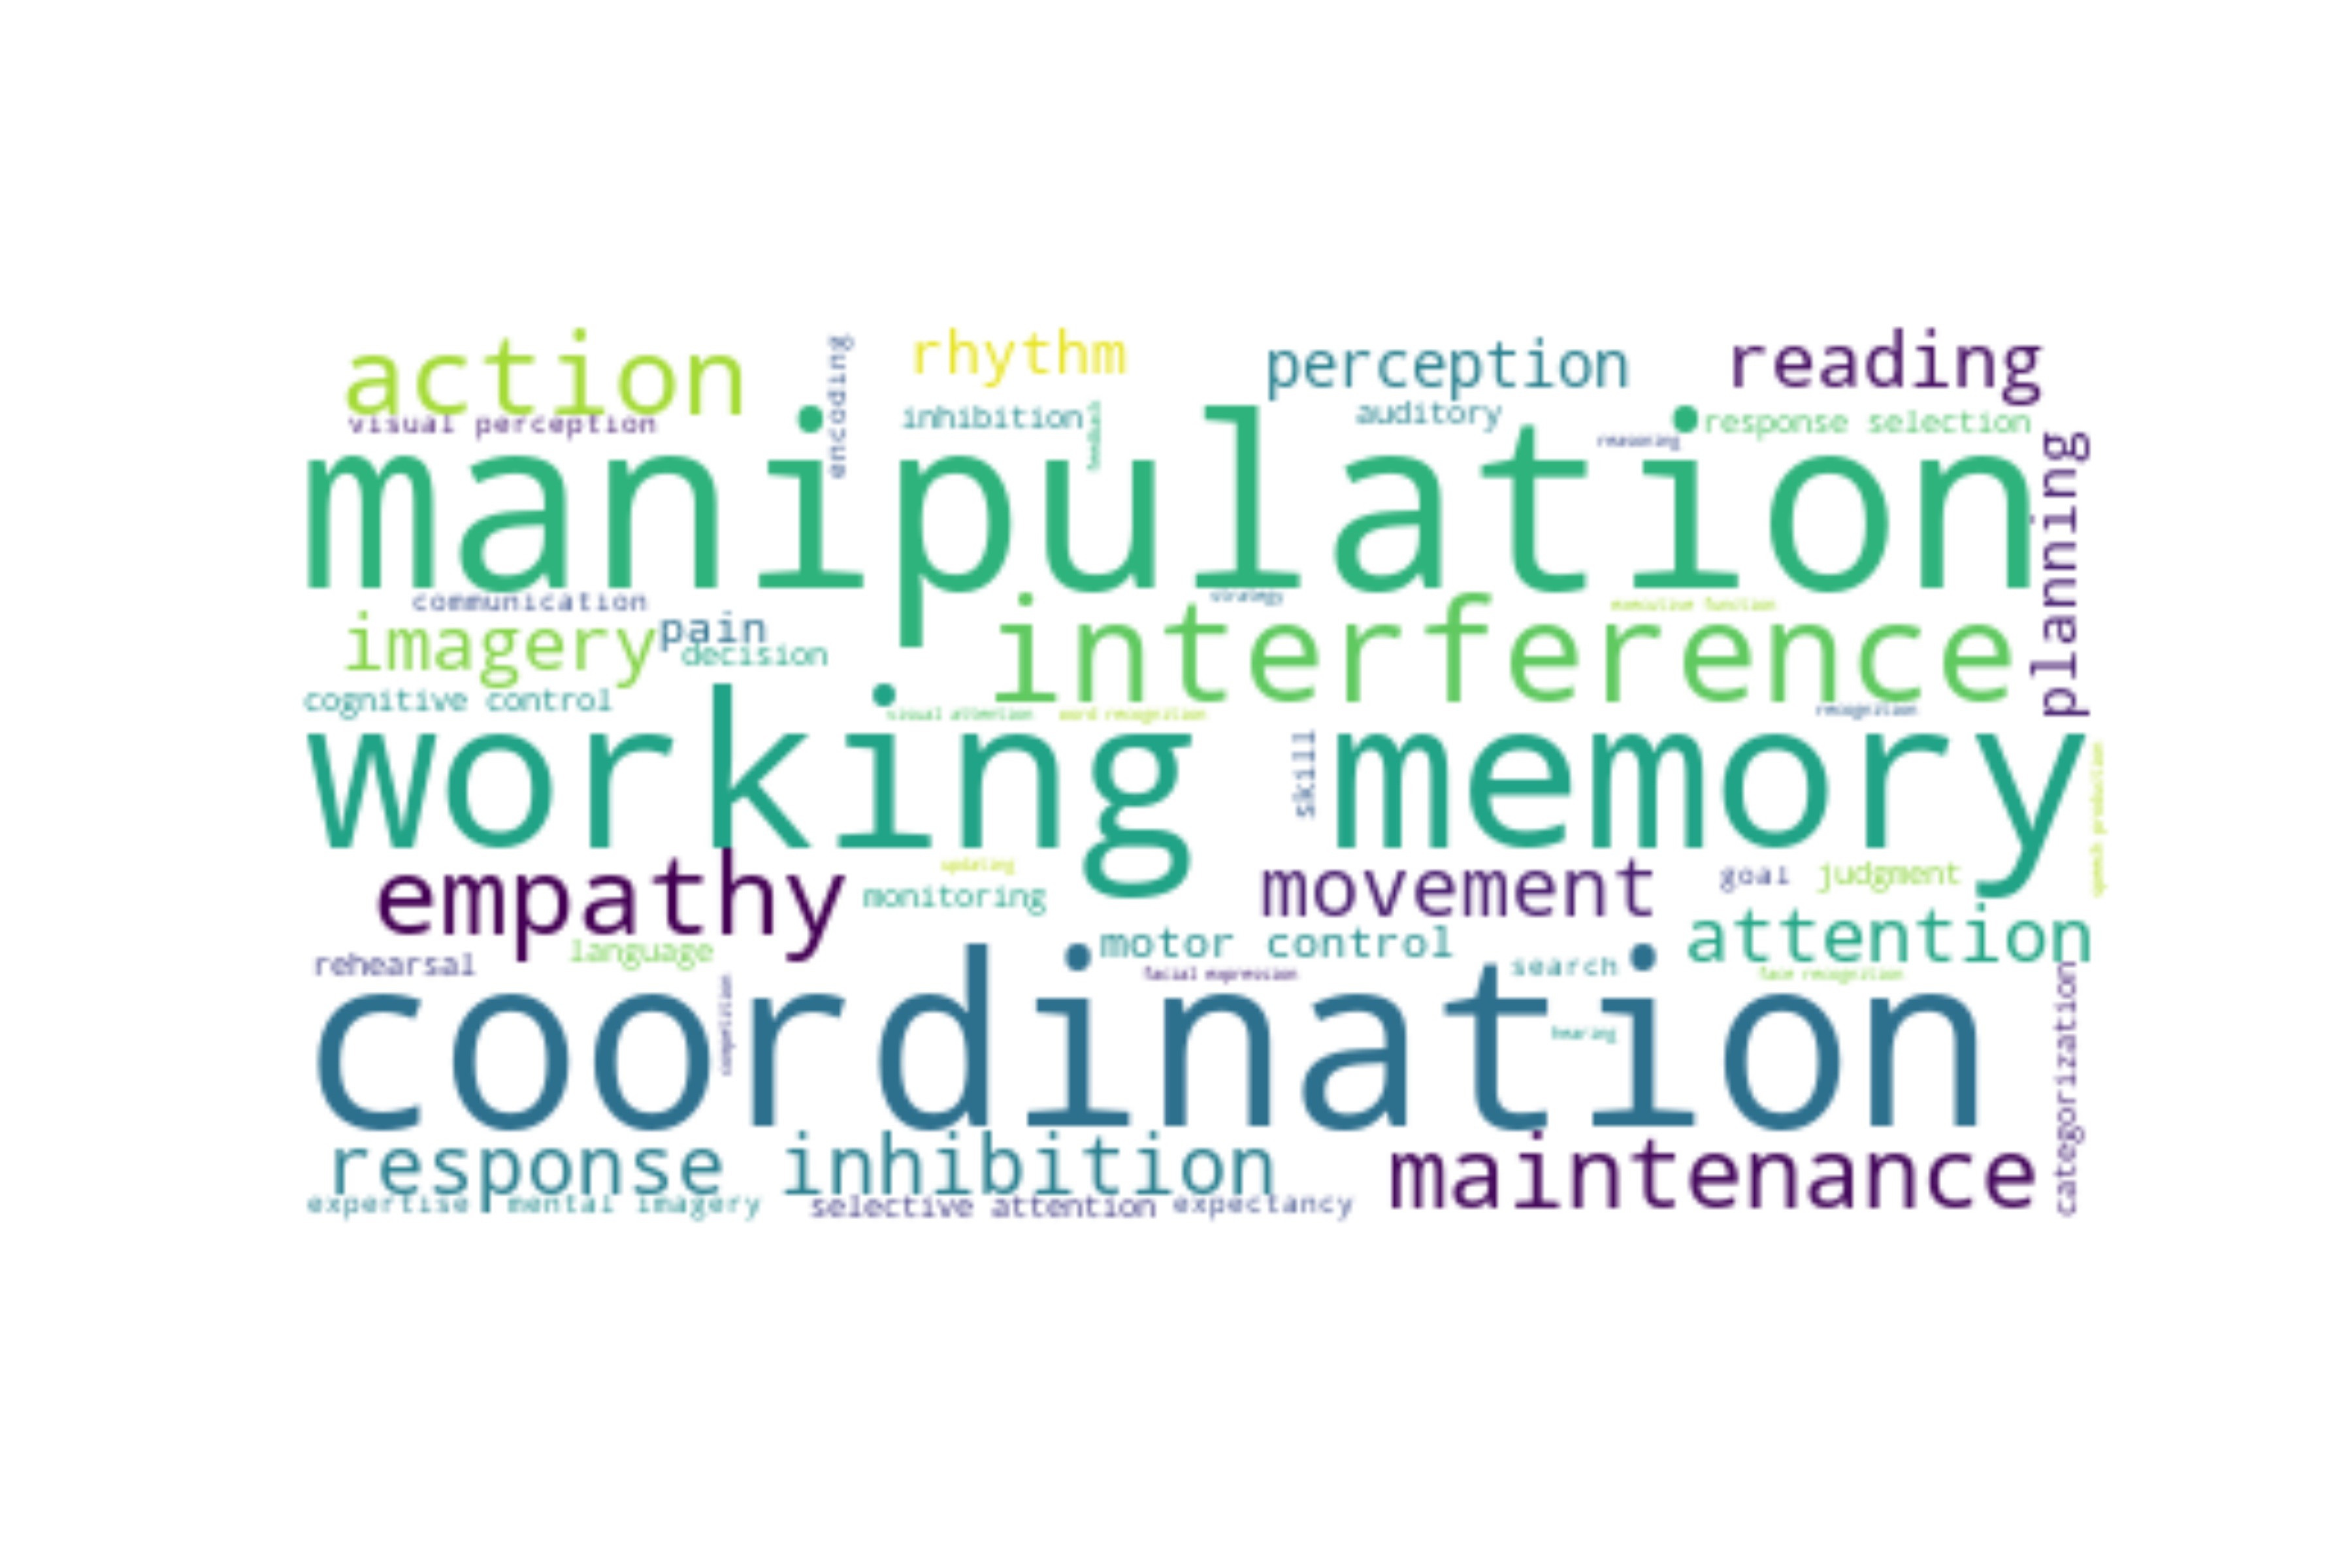

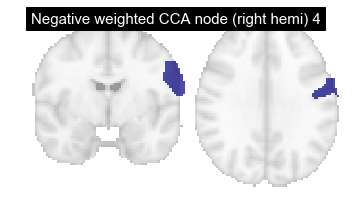

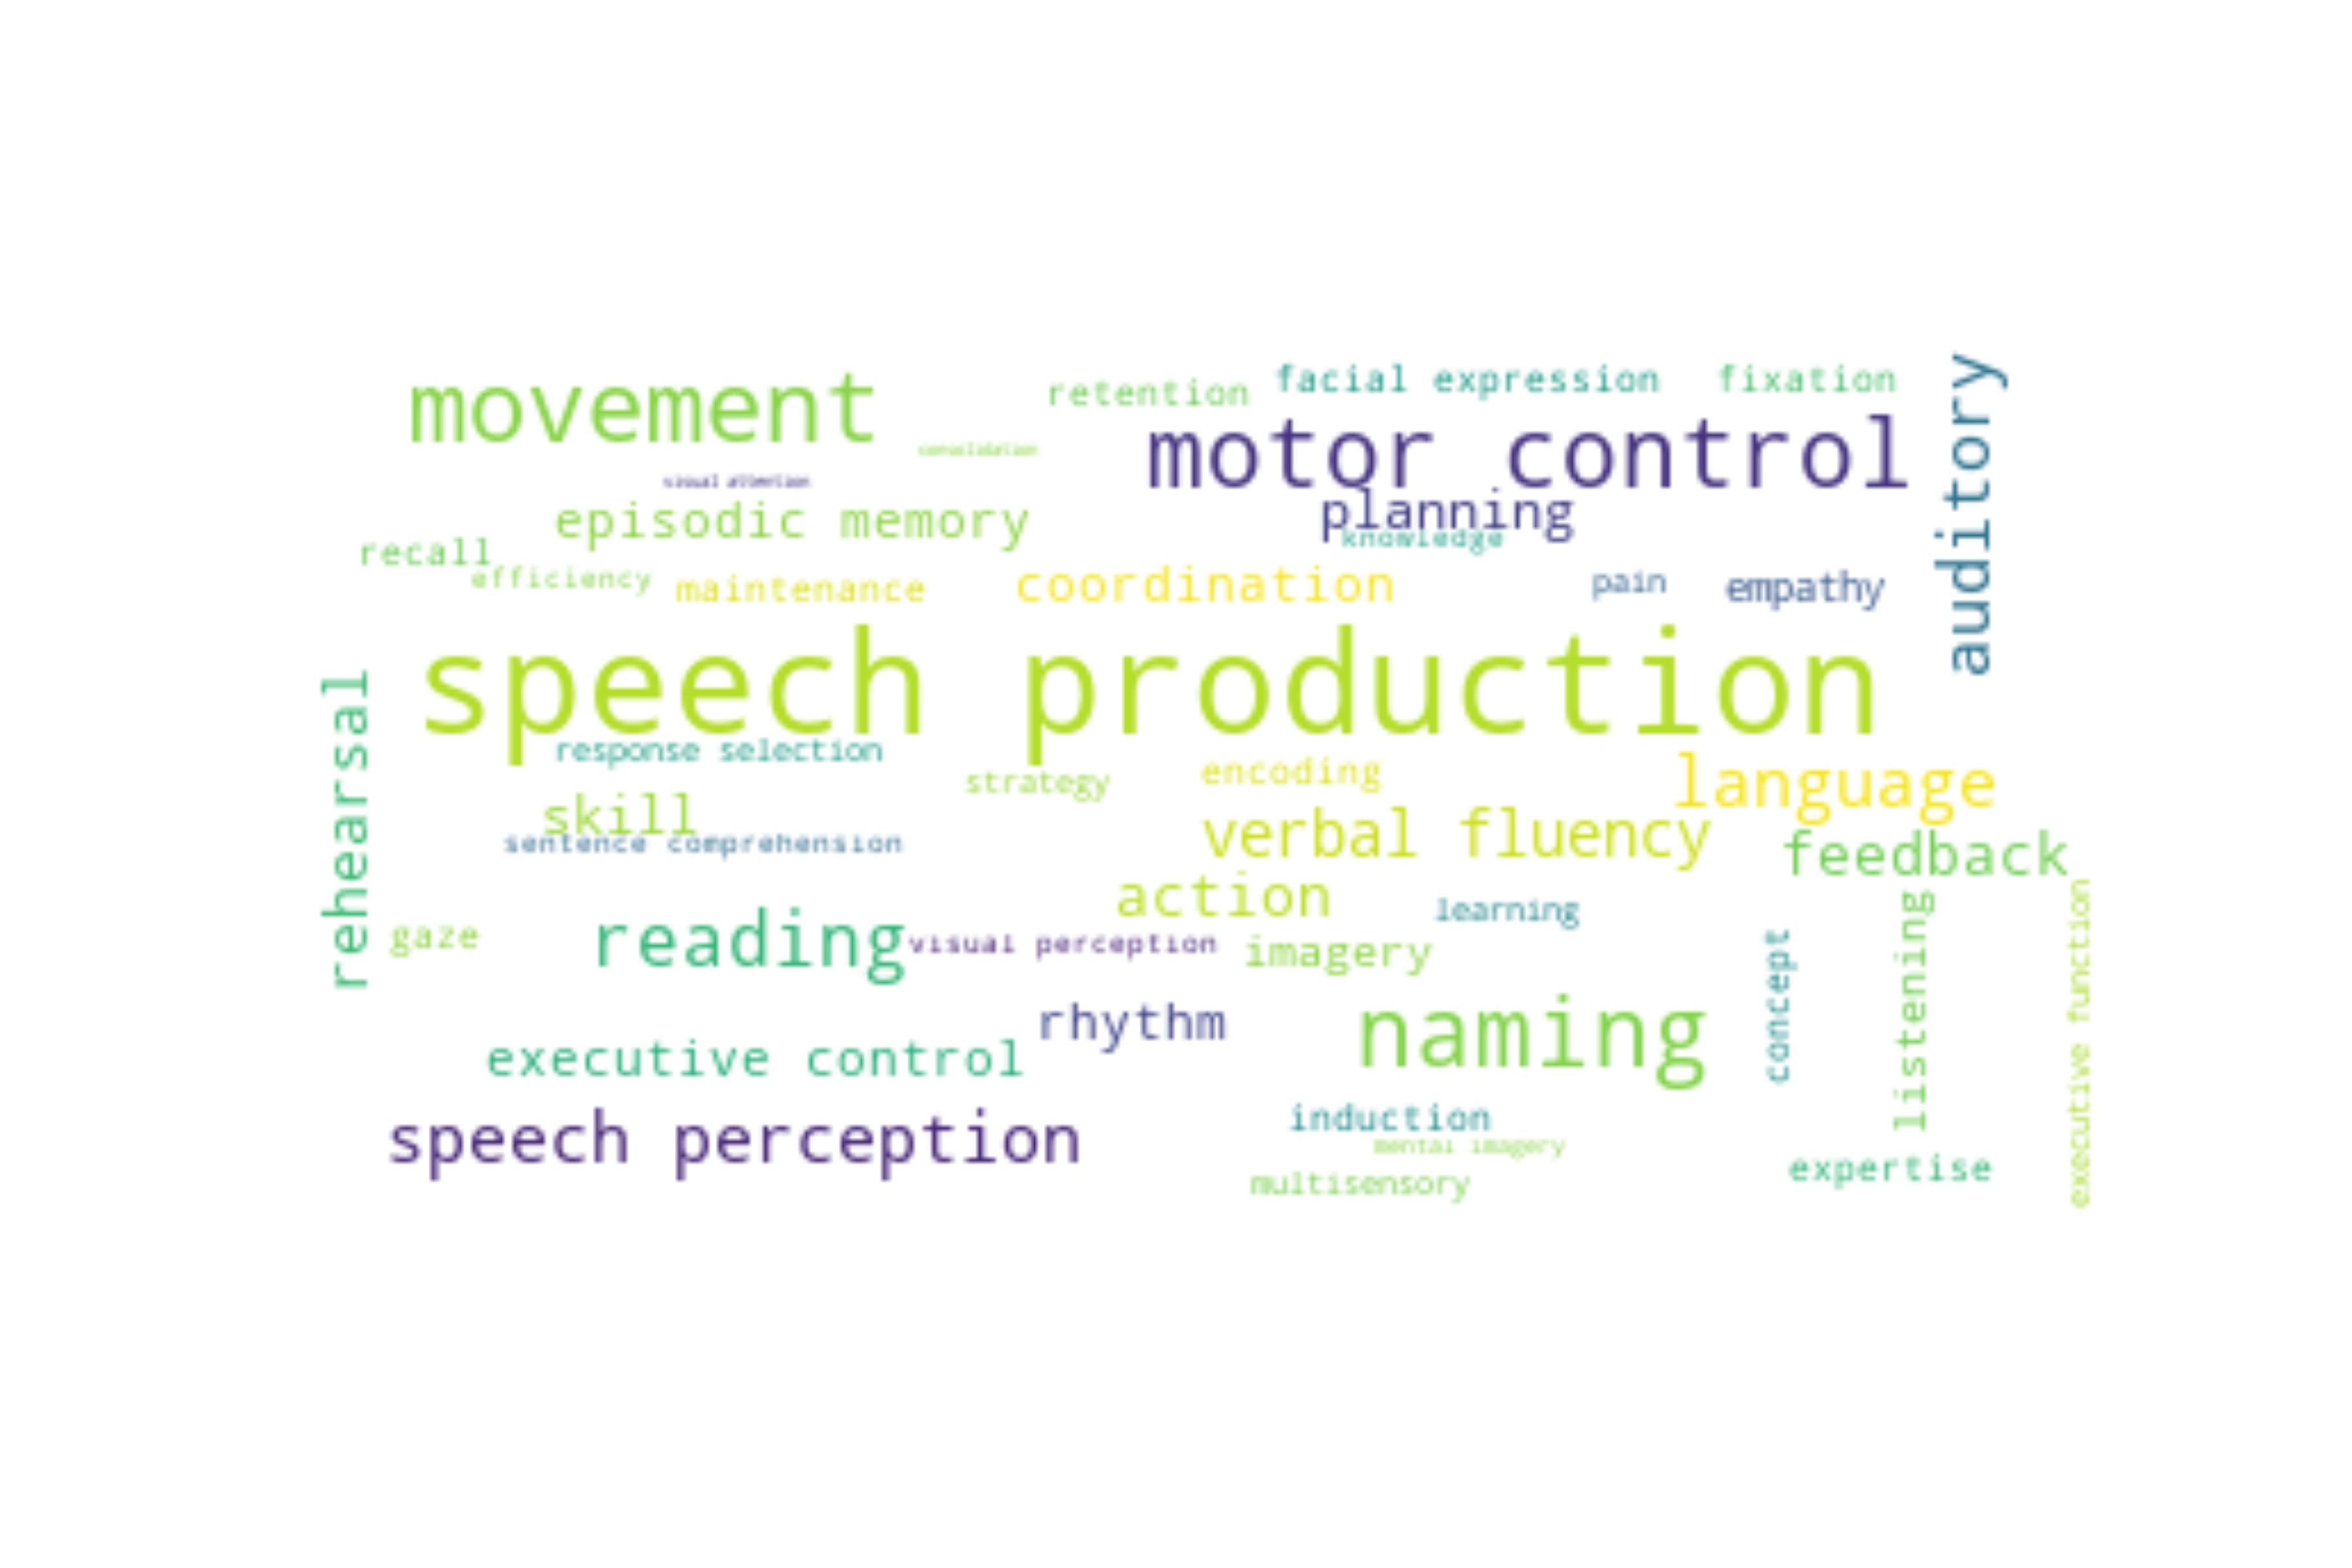

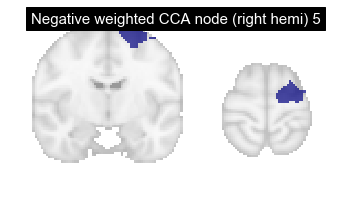

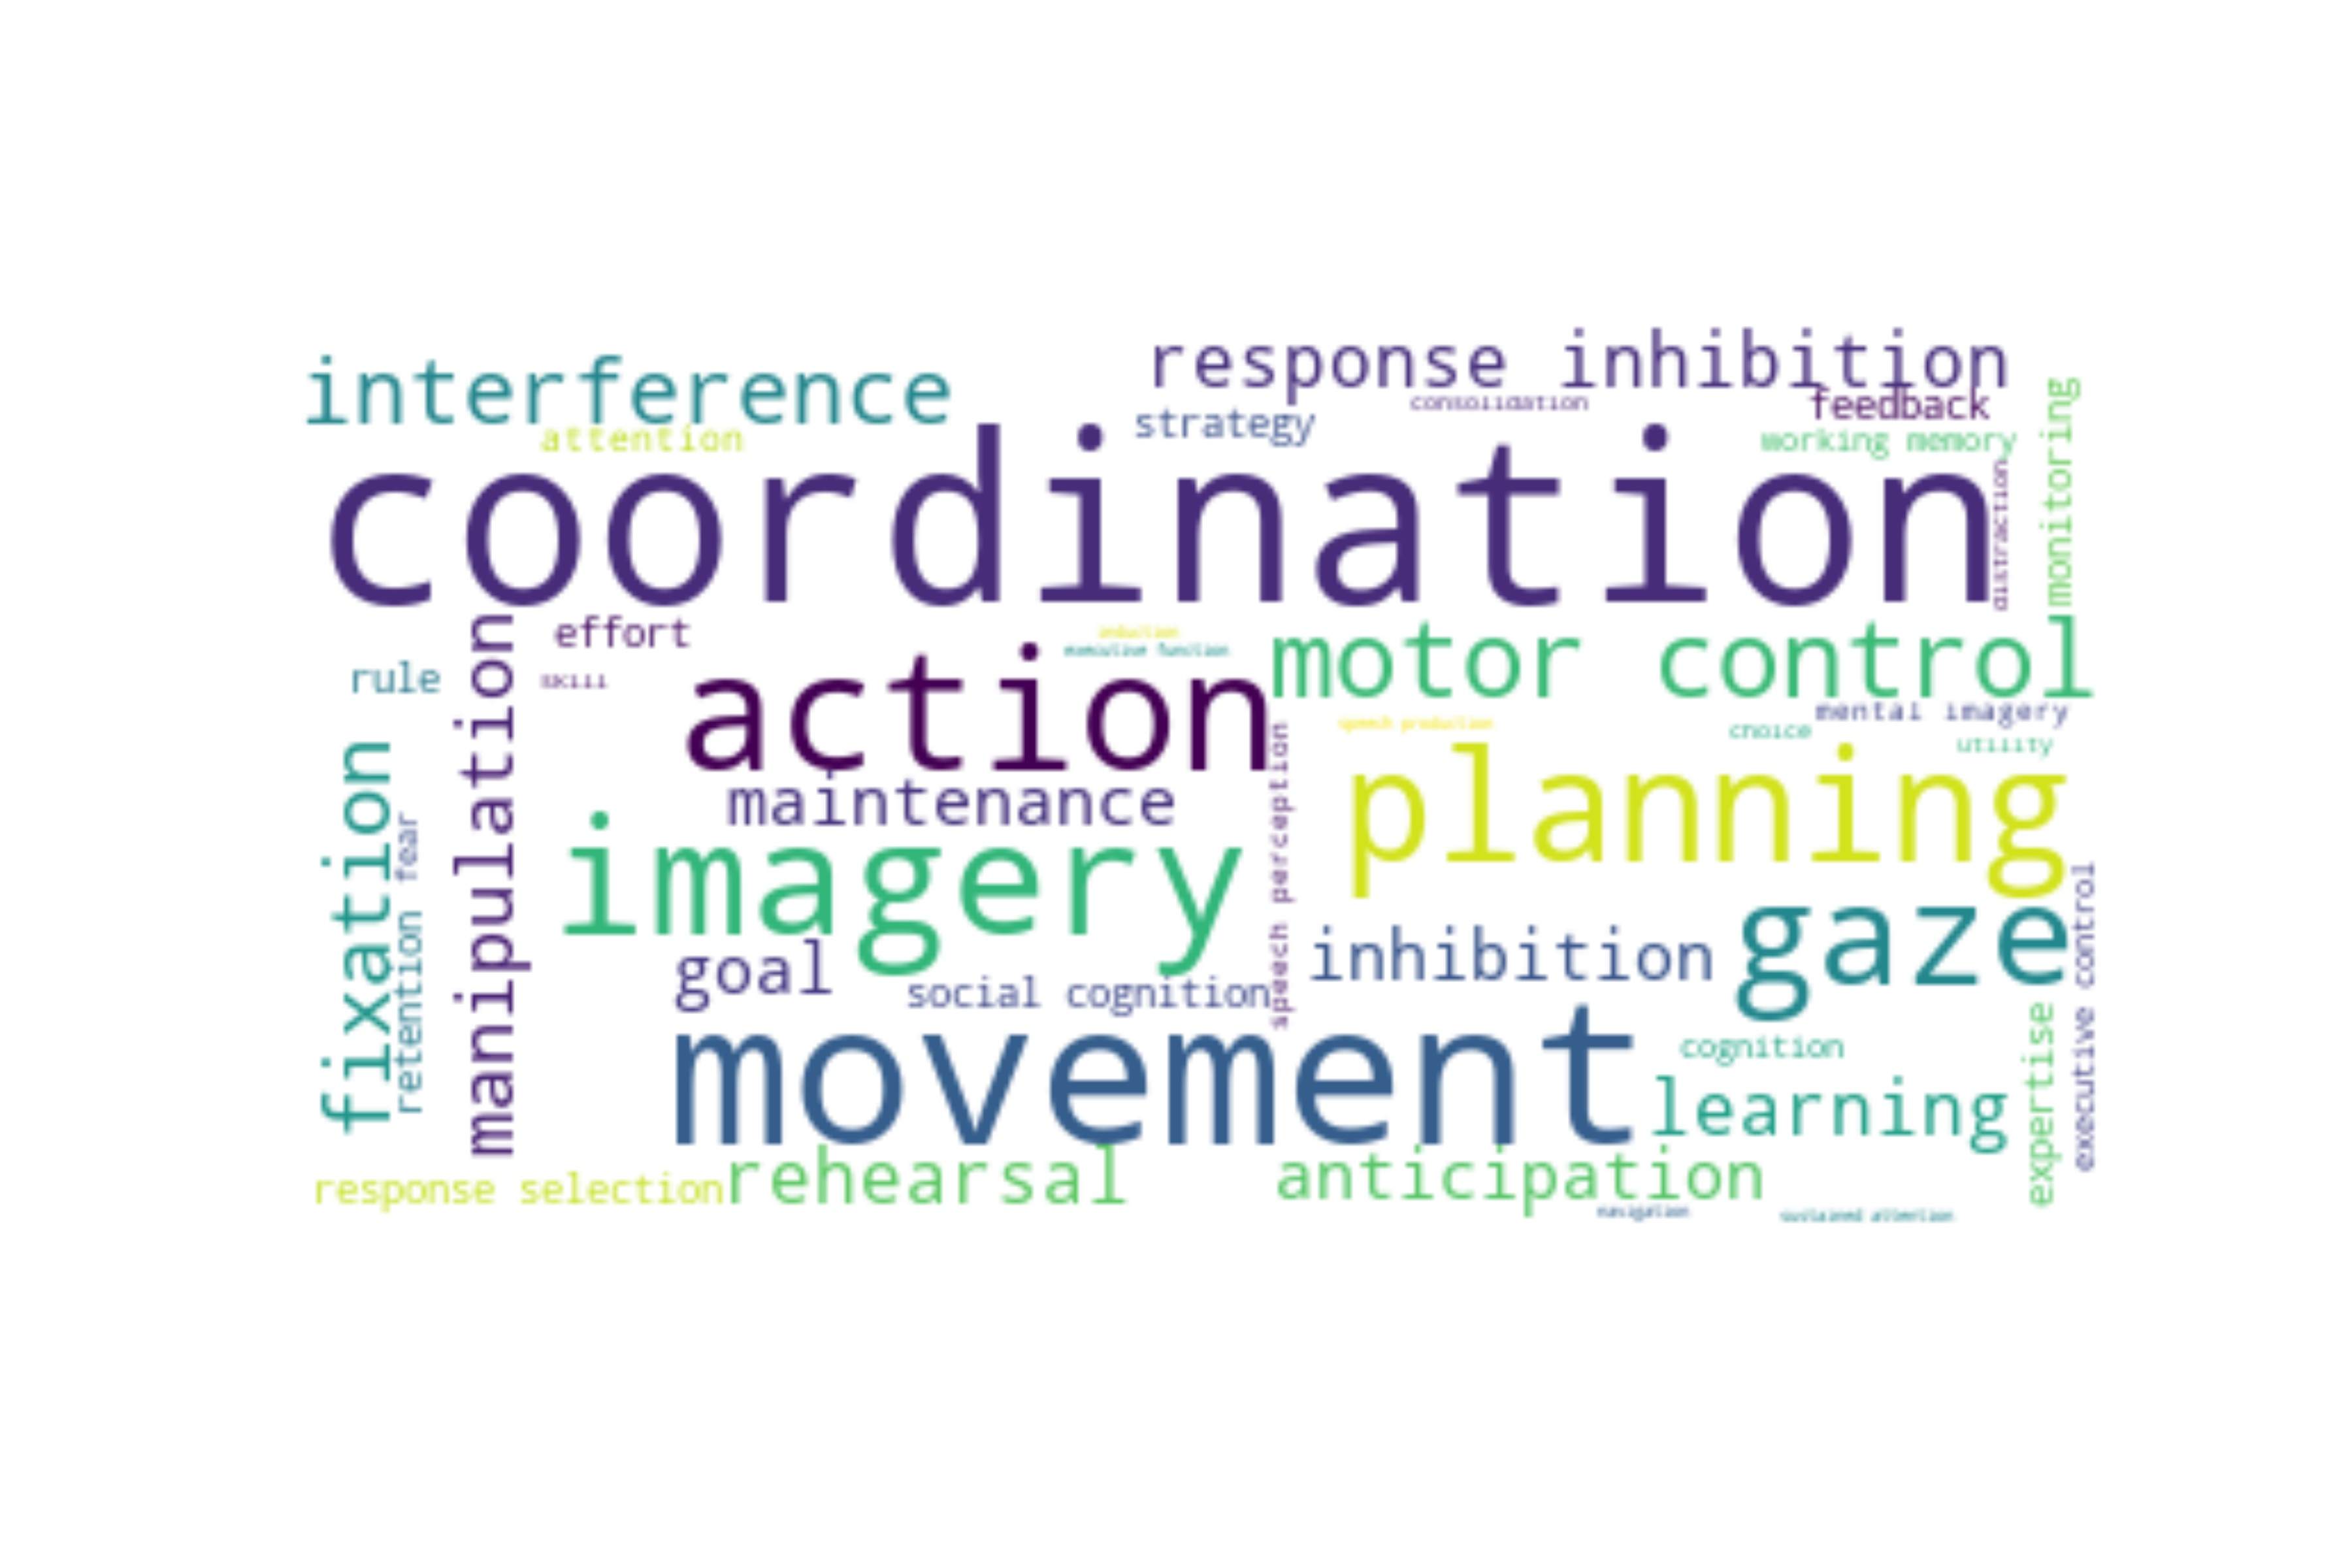

In [9]:
# display roi brain plots and word clouds
from IPython.display import Image, display
path_to_neurosynthdata = '/Users/luke/Documents/Projects/StrokeNet/Data/topicMapping/'

nodes = data['CCA'][0][0][14]
n_nodes = 5
roi_list = np.ravel(np.vstack((nodes[0:n_nodes,0,mode],nodes[0:n_nodes,1,mode])))
nii_list=[]
for nii in range(n_nodes*2):
    roi = roi_list[nii]
    nii = parc+'_roi_'+str(roi)
    nii_list.append(path_to_neurosynthdata+'roi/'+nii+'.nii')

mode = 0
i = 1

for i,roi in enumerate(roi_list):
    nii = nii_list[i]
    if i < 5:
        label = 'Positive weighted CCA node (left hemi) '+str(i+1)
    else:
        label = 'Negative weighted CCA node (right hemi) '+str(i-4)
    #brain
    plotting.plot_roi(nii,threshold=0.1, title=label,draw_cross=False,display_mode='yz',dim=2,annotate=False)
    plotting.show()

    # word cloud
    fname = path_to_neurosynthdata+'word_clouds/decoding_results_roi'+str(i)+'_'+parc+'_mode'+str(mode)+'_trimmed.jpeg'
    display(Image(filename=fname,width=500))

# Supplementary figures and analysis

Various supplemental analyses.

## Mode 2?
Arguably the permutation approach taken <cite data-cite="1496076/84MBLIL2"></cite> is a harsh on canonical variates beyond the first. Is Mode 2 interesting and or helpful to interpet?

Maybe yes! It predicts the language task that could not be predicted in mode 1 reasonably well. It is associated with damage to a left-hemisphere superior network. Need to think what this might mean in terms of localisation.

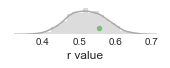

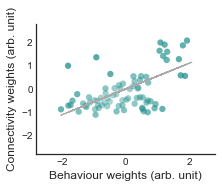

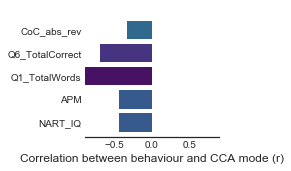

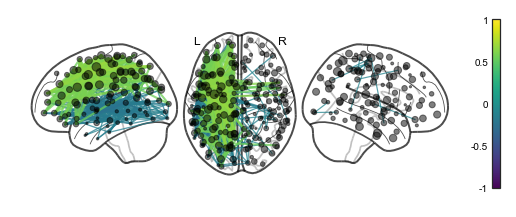

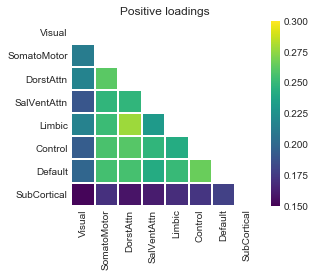

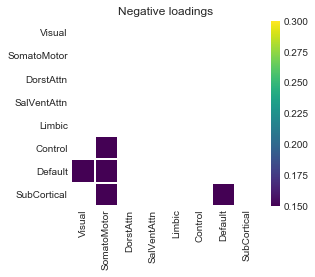

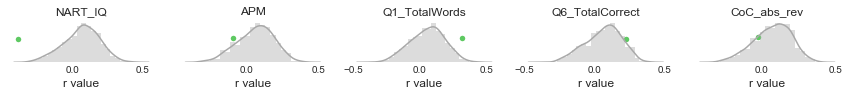

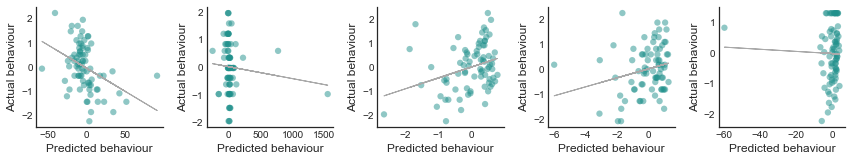

In [10]:
#plot CCA results for mode 2
mode = 1
U = data['CCA'][0][0][2]
V = data['CCA'][0][0][3]
r = data['CCA'][0][0][4]
r_perms = data['CCA'][0][0][9]
behaviour_loading = data['CCA'][0][0][12]
modes = data['CCA'][0][0][11]
real_values = data['CCA'][0][0][6]
predicted_values = data['CCA'][0][0][5]

predicted_values = predicted_values[:, :, mode]
r_values = data['CCA'][0][0][7]
r_values = r_values[:,mode]
perm_r_values = data['CCA'][0][0][10]

U = U[:, :, mode]
U = np.nanmean(U, axis=1)
V = V[:, :, mode]
V = np.nanmean(V, axis=1)
r = r[:, mode]

mode_UV_plot(U, V, r, r_perms)
mode_BW_plot(behaviour_loading[:, mode])

cm = modes[:, :, mode] + modes[:, :, mode].T
cm_degree = np.sum(abs(cm), axis=1)
cm = do_threshold(cm, num_edge=500)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 75
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=-1,
                         edge_vmax=1,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.75},
                         node_kwargs={'Alpha': 0.50},
                         colorbar=True)
plotting.show()

#network level description
net_values = data['CCA'][0][0][13]
#positive
pos = net_values[:, :, 0, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos,
            vmin=0.15,
            vmax=0.3,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Positive loadings')
plt.show()

#negative
pos = net_values[:, :, 1, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos * -1,
            vmin=0.15,
            vmax=0.3,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Negative loadings')
plt.show()
mode_prediction_plot(real_values, predicted_values, r_values, perm_r_values)

## Behavioural data transform
After the transform no behavioural data violates normality assumptions

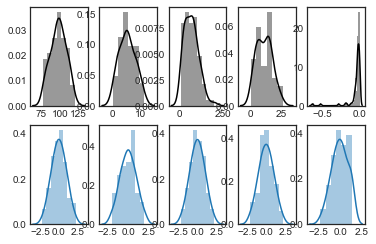

In [11]:
#plot behavioural transforms
beh = data['behav'][0][0][2]
beh_tf = data['behav'][0][0][4]
num_beh = np.shape(beh_tf)[1]
for measure in range(num_beh):
    plt.subplot(2, num_beh, measure + 1)
    sns.distplot(beh[:, measure], color='black')
    plt.subplot(2, num_beh, measure + 1 + num_beh)
    sns.distplot(beh_tf[:, measure])
plt.show()

## What happens if you perform the CCA on the voxels?
- 1) Left - right axis is the same.
- 2) Predictions are not as impressive. Presumably because it doesn't seem to capture as many subject's data (many 0-loadings)

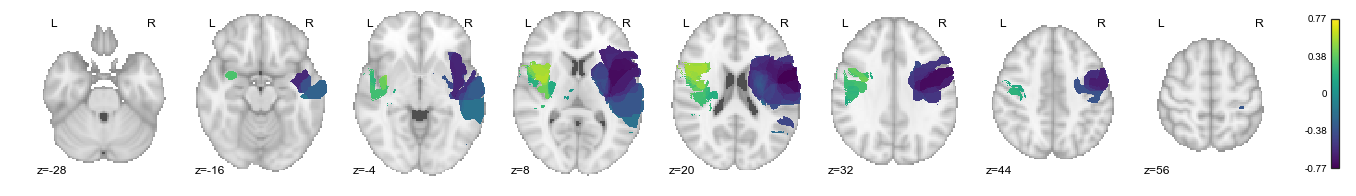

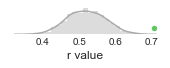

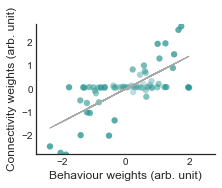

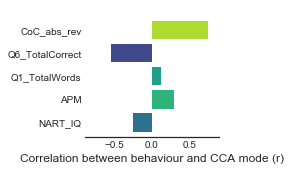

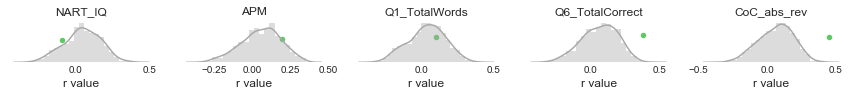

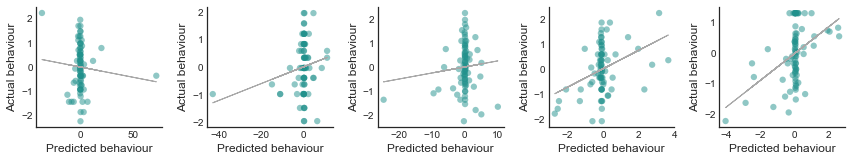

In [12]:
#voxelwise CCA results
mode = 0
img = '/Users/luke/Documents/Projects/StrokeNet/Docs/Results/voxelwise/CCA_Mode' + str(
    mode + 1) + '.nii'
slices = np.arange(-28, 62, 12)
plotting.plot_stat_map(img,
                       threshold=0,
                       colorbar=True,
                       cmap='viridis',
                       display_mode='z',
                       cut_coords=(slices))
plt.show()

results_dir = docs_path + 'Results/voxelwise/'
data_v = scipy.io.loadmat(results_dir + 'results.mat')
U = data_v['CCA'][0][0][2]
V = data_v['CCA'][0][0][3]
r = data_v['CCA'][0][0][4]
r_perms_v = data['CCA'][0][0][9]
behaviour_loading = data_v['CCA'][0][0][13]

U = U[:, :, mode]
U = np.nanmean(U, axis=1)
V = V[:, :, mode]
V = np.nanmean(V, axis=1)
r = r[:, mode]

mode_UV_plot(U, V, r, r_perms)
mode_BW_plot(behaviour_loading[:, mode])

real_values = data_v['CCA'][0][0][6]
predicted_values = data_v['CCA'][0][0][5]
predicted_values = predicted_values[:, :, mode]
r_values = data_v['CCA'][0][0][7]
r_values = r_values[:,mode]
perm_r_values = data_v['CCA'][0][0][10]
mode_prediction_plot(real_values, predicted_values, r_values, perm_r_values)

### Empirical comparison to connectivity based CCA

## Single example lesion subject
Note the widespread effects of a lesion

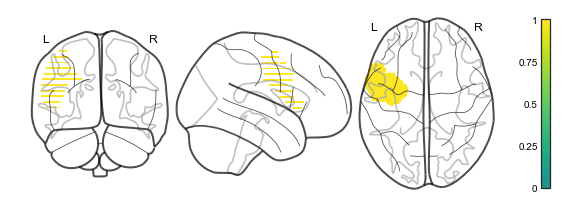

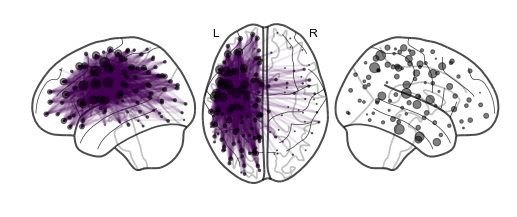

In [13]:
#single sub example
img = '/Users/luke/Documents/Projects/StrokeNet/Data/lesionMaps/3_rNii/rP002_SP.nii'
plotting.plot_glass_brain(img, threshold=0, colorbar=True, cmap='viridis')
cm = data['Cdiff']
cm = cm[:, :, 1] > 0
cm = cm + cm.T
cm_degree = np.sum(abs(cm), axis=1)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 100
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=1,
                         edge_vmax=2,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.10},
                         node_kwargs={'Alpha': 0.50})
plt.show()

## Replication in another parcellation
Results look very similar.

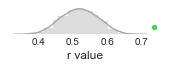

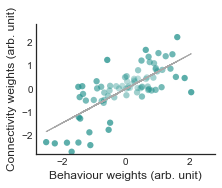

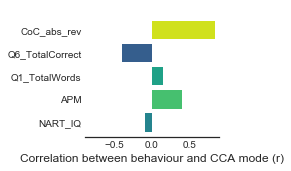

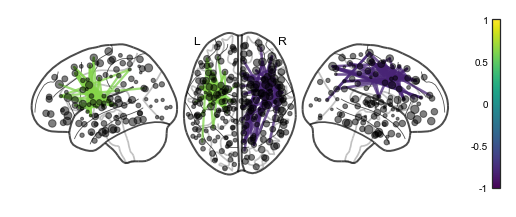

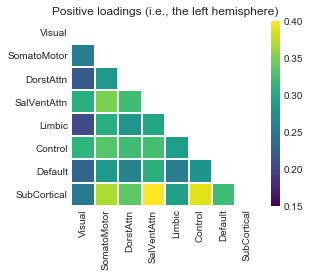

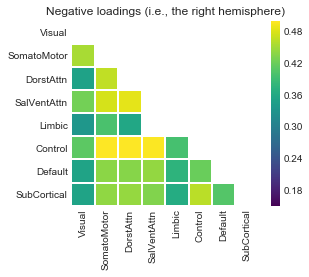

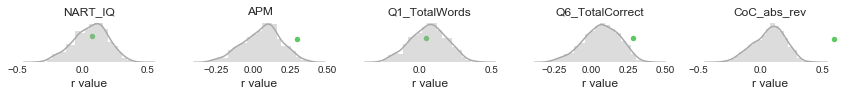

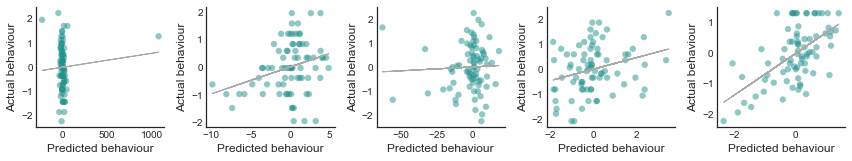

In [14]:
# Brainnetome atlas results
docs_path = '/Users/luke/Documents/Projects/StrokeNet/Docs/'
parc = 'BN'
conbound = 'conbound20/'
results_dir = docs_path + 'Results/' + conbound + parc + '/'
data = scipy.io.loadmat(results_dir + 'results.mat')

#network info
MNIcoordinates = data['COG']
U = data['CCA'][0][0][2]
V = data['CCA'][0][0][3]
r = data['CCA'][0][0][4]
r_perms = data['CCA'][0][0][9]
behaviour_loading = data['CCA'][0][0][12]
modes = data['CCA'][0][0][11]
real_values = data['CCA'][0][0][6]
predicted_values = data['CCA'][0][0][5]
mode = 0
predicted_values = predicted_values[:, :, mode]
r_values = data['CCA'][0][0][7]
r_values = r_values[:,mode]
perm_r_values = data['CCA'][0][0][10]

U = U[:, :, mode]
U = np.nanmean(U, axis=1)
V = V[:, :, mode]
V = np.nanmean(V, axis=1)
r = r[:, mode]

mode_UV_plot(U, V, r, r_perms)
mode_BW_plot(behaviour_loading[:, mode])

cm = modes[:, :, mode] + modes[:, :, mode].T
cm_degree = np.sum(abs(cm), axis=1)
cm = do_threshold(cm, num_edge=100)
cm_degree_plot = (cm_degree / np.max(cm_degree)) * 75
plotting.plot_connectome(cm,
                         MNIcoordinates,
                         node_size=cm_degree_plot,
                         node_color='black',
                         edge_cmap='viridis',
                         edge_vmin=-1,
                         edge_vmax=1,
                         display_mode='lzr',
                         edge_kwargs={'Alpha': 0.75},
                         node_kwargs={'Alpha': 0.50},
                         colorbar=True)
plotting.show()

#network level description
net_values = data['CCA'][0][0][13]
#positive
pos = net_values[:, :, 0, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos,
            vmin=0.15,
            vmax=0.4,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Positive loadings (i.e., the left hemisphere)')
plt.show()

#negative
pos = net_values[:, :, 1, mode]
mask = np.zeros_like(pos)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(4.2, 3.4))
sns.heatmap(pos * -1,
            vmin=0.15,
            vmax=0.5,
            cmap='viridis',
            annot=False,
            fmt='.2f',
            mask=mask,
            linewidths=1,
            xticklabels=net_labels,
            yticklabels=net_labels)
plt.title('Negative loadings (i.e., the right hemisphere)')
plt.show()

mode_prediction_plot(real_values, predicted_values, r_values, perm_r_values)

In [16]:
#command to export this notebook
#jupyter nbconvert StrokeNetProject.ipynb --to pdf --TemplateExporter.exclude_input_prompt=True --TemplateExporter.exclude_output_prompt=True --TemplateExporter.exclude_input=True 